# Libraries and Imports

In [1]:
# import relevant libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# preprocessing modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as nltk_stopwords, wordnet
import regex as re
import nltk
from nltk import pos_tag, word_tokenize

# sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textblob
from textblob import TextBlob

# lda
import gensim

# machine learning libraries and modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, SpatialDropout1D
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

In [2]:
sns.set_theme(style='whitegrid', font='cambria')
sns.set_palette('twilight_shifted')

# Read in Datasets

In [3]:
pubg_df = pd.read_csv('datasets/pubg.csv')
cyberpunk_df = pd.read_csv('datasets/cyberpunk.csv')
fallguys_df = pd.read_csv('datasets/fallguys.csv')

In [4]:
# create dictionary of dataframes and names

dfs = {"PlayerUnknown's Battlegrounds": pubg_df, 
       "Cyberpunk 2077": cyberpunk_df, 
       "Fall Guys": fallguys_df
      }

# Lexicon-based Sentiment Analysis

We will use the libraries `vaderSentiment` and `TextBlob` to determine the overall sentiment of each review. As punctuation is also indicative of sentiment to some extent, we will use the cleaned text with punctuation retained to perform this analysis.

## Vader for Sentiment Analysis

**Compound Score (CS)**

- Positive sentiment: CS >= 0.05
- Neutral sentiment: -0.05 < CS < 0.05
- Negative sentiment: CS <= -0.05

In [5]:
# initialize SentimentIntensityAnalyzer and calculate compound score for each game

analyser = SentimentIntensityAnalyzer()

for df in dfs.values():
    df['vader_score'] = df['clean_text_punct'].apply(lambda x: analyser.polarity_scores(x)['compound'])

## Textblob for Sentiment Analysis

The output of `textblob`'s sentiment analysis includes the polarity and subjectivity scores, both of which are defined as follows:

**Polarity** 

`float` between [-1,1]: 1 means a positive statement and -1 means a negative statement 

**Subjectivity** 

`float` bewteen [0,1]: 0 means a factual statement and 1 means a subjective statement

In [6]:
def textblob_sentiment_scores(sentence):
    blob = TextBlob(sentence)
    return blob.sentiment.polarity

In [7]:
for df in dfs.values():
    df['textblob_score'] = df['clean_text_punct'].apply(textblob_sentiment_scores)

## Comparison of Vader and Textblob's sentiment scores

In [8]:
def compare_vader_textblob(df, df_name):
    plt.figure(figsize=(10, 8))
    df['vader_score'].hist(alpha=1, bins=20, label='Vader')
    df['textblob_score'].hist(alpha=0.5, bins=20, label='Textblob');
    plt.title(f'Histogram of Vader and Textblob sentiment scores for {df_name}', fontsize=20);
    plt.legend();

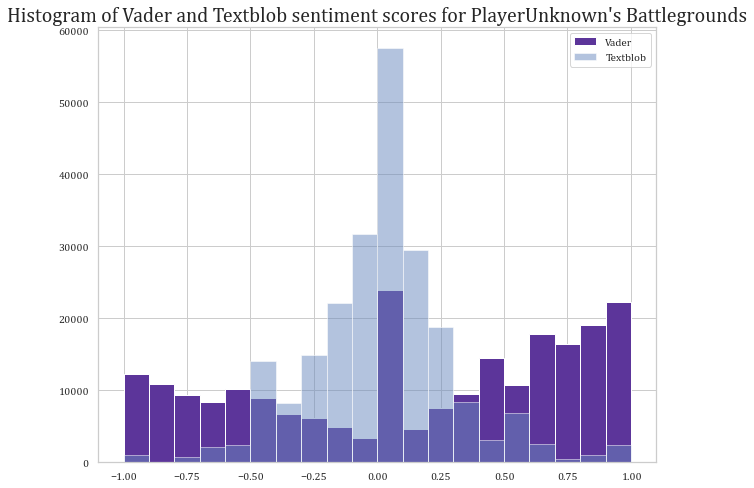

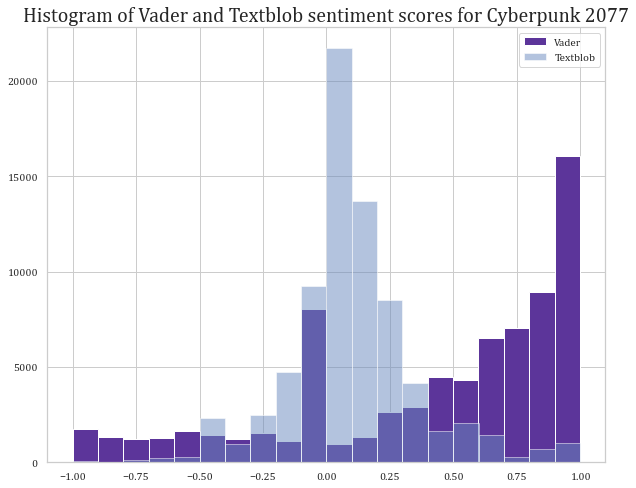

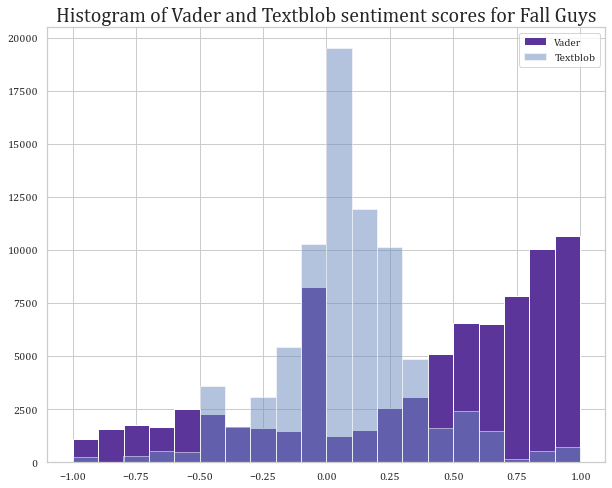

In [9]:
for df_name, df in dfs.items():
    compare_vader_textblob(df, df_name)

In general, Vader outputs a broader range of sentiments between -1 and 1.

Textblob is highly clustered at the neutral ~0.00 range.

## Comparison of Lexicon-based Sentiment Scores with Actual

We first convert the Lexicon-based sentiment scores into either positive or negative scores, based on the range of scores.

We take all scores <= -0.05 and below to be negative, and scores >= 0.05 to be positive, dropping scores that are between -0.05 to 0.05 purely for this analysis.

Spam comments that do not harbour any sentiment would also be filtered out using this method.

In [10]:
def encode_polarity_score(score):
    if score >= 0.05:
        return 1
    elif score <= -0.05:
        return 0
    else:
        return None

In [11]:
for df_name, df in dfs.items():
    
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(f'Number of rows before encoding: {df.shape[0]}')
    
    no_rows_initial = df.shape[0]
    
    df['textblob_pred'] = df['textblob_score'].apply(encode_polarity_score)
    df['vader_pred'] = df['vader_score'].apply(encode_polarity_score)
    df.dropna(axis=0, subset=['textblob_pred', 'vader_pred'], inplace=True)
    print(f'Number of rows after encoding: {df.shape[0]}')
    
    no_rows_final = df.shape[0]
    
    print(f'Rows dropped: {no_rows_initial - no_rows_final}')

-------
PlayerUnknown's Battlegrounds
-------
Number of rows before encoding: 227901
Number of rows after encoding: 159470
Rows dropped: 68431
-------
Cyberpunk 2077
-------
Number of rows before encoding: 75663
Number of rows after encoding: 52942
Rows dropped: 22721
-------
Fall Guys
-------
Number of rows before encoding: 78990
Number of rows after encoding: 56947
Rows dropped: 22043


In [135]:
# define a function to calculate the accuracy scores, generate and display confusion matrix for each game

def lexicon_scorer(df, df_name):
    
    # generate accuracy scores
    baseline_acc_score = df['label'].value_counts(normalize=True)[1]
    vader_acc_score = accuracy_score(df['label'], df['vader_pred'])
    textblob_acc_score = accuracy_score(df['label'], df['textblob_pred'])
    
    print(f'Baseline accuracy score ------------------: {baseline_acc_score:.5f}')
    print(f'Accuracy score on Vader predictions ------: {vader_acc_score:.5f}')
    print(f'Accuracy score on Textblob predictions ---: {textblob_acc_score:.5f}')
    
    print('--------')
    print(f'Classification Report for {df_name} - Vader')
    print('--------')
    print(classification_report(df['label'], df['vader_pred']))
     
    print('--------')
    print(f'Classification Report for {df_name} - Textblob')
    print('--------')
    print(classification_report(df['label'], df['textblob_pred']))
            
    # generate confusion matrices
    df_vader_cm = confusion_matrix(df['label'], df['vader_pred'])
    df_textblob_cm = confusion_matrix(df['label'], df['textblob_pred'])
    
    # display confusion matrices
    figure, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
          
    ConfusionMatrixDisplay(df_vader_cm).plot(ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(f'Vader Confusion Matrix for {df_name}', fontsize=20)
                    
    ConfusionMatrixDisplay(df_textblob_cm).plot(ax=ax[1])
    ax[1].grid(False)
    ax[1].set_title(f'Textblob Confusion Matrix for {df_name}', fontsize=20);
    plt.tight_layout();

### PUBG

Baseline accuracy score ------------------: 0.57326
Accuracy score on Vader predictions ------: 0.76743
Accuracy score on Textblob predictions ---: 0.74652
--------
Classification Report for PUBG - Vader
--------
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     68052
           1       0.78      0.83      0.80     91418

    accuracy                           0.77    159470
   macro avg       0.76      0.76      0.76    159470
weighted avg       0.77      0.77      0.77    159470

--------
Classification Report for PUBG - Textblob
--------
              precision    recall  f1-score   support

           0       0.69      0.74      0.71     68052
           1       0.79      0.75      0.77     91418

    accuracy                           0.75    159470
   macro avg       0.74      0.75      0.74    159470
weighted avg       0.75      0.75      0.75    159470



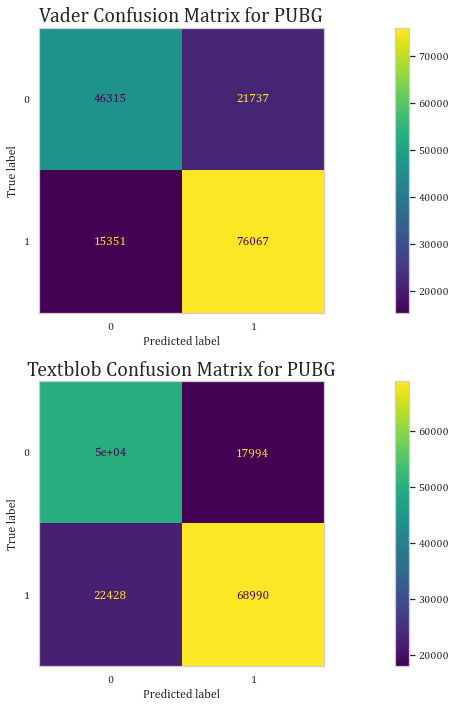

In [136]:
# display scores and CM for PUBG

lexicon_scorer(pubg_df, 'PUBG')

### Cyberpunk

Baseline accuracy score ------------------: 0.81168
Accuracy score on Vader predictions ------: 0.84232
Accuracy score on Textblob predictions ---: 0.81346
--------
Classification Report for Cyberpunk - Vader
--------
              precision    recall  f1-score   support

           0       0.59      0.54      0.57      9970
           1       0.90      0.91      0.90     42972

    accuracy                           0.84     52942
   macro avg       0.74      0.73      0.73     52942
weighted avg       0.84      0.84      0.84     52942

--------
Classification Report for Cyberpunk - Textblob
--------
              precision    recall  f1-score   support

           0       0.50      0.65      0.57      9970
           1       0.91      0.85      0.88     42972

    accuracy                           0.81     52942
   macro avg       0.71      0.75      0.72     52942
weighted avg       0.84      0.81      0.82     52942



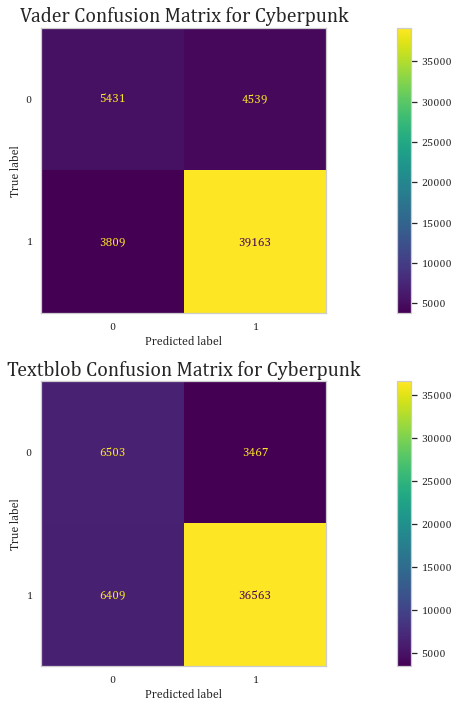

In [137]:
# display scores and CM for Cyberpunk

lexicon_scorer(cyberpunk_df, 'Cyberpunk')

### Fall Guys

Baseline accuracy score ------------------: 0.81534
Accuracy score on Vader predictions ------: 0.82756
Accuracy score on Textblob predictions ---: 0.75182
--------
Classification Report for Fall Guys - Vader
--------
              precision    recall  f1-score   support

           0       0.53      0.63      0.57     10516
           1       0.91      0.87      0.89     46431

    accuracy                           0.83     56947
   macro avg       0.72      0.75      0.73     56947
weighted avg       0.84      0.83      0.83     56947

--------
Classification Report for Fall Guys - Textblob
--------
              precision    recall  f1-score   support

           0       0.40      0.69      0.51     10516
           1       0.92      0.77      0.83     46431

    accuracy                           0.75     56947
   macro avg       0.66      0.73      0.67     56947
weighted avg       0.82      0.75      0.77     56947



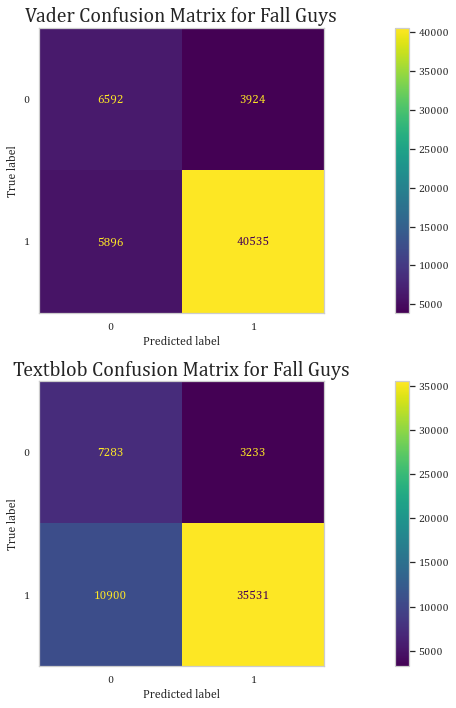

In [138]:
# display scores and CM for Fall Guys

lexicon_scorer(fallguys_df, 'Fall Guys')

In [16]:
# put results into a dataframe for easy comparison

lexicon_scores = {}

for df_name, df in dfs.items():
    
    # generate accuracy scores and baseline score
    vader_acc_score = accuracy_score(df['label'], df['vader_pred'])
    textblob_acc_score = accuracy_score(df['label'], df['textblob_pred'])
    baseline_acc_score = df['label'].value_counts(normalize=True)[1]
    
    # add scores to dictionary
    lexicon_scores[df_name] = [baseline_acc_score, vader_acc_score, textblob_acc_score]
       
lexicon_df = pd.DataFrame(data=lexicon_scores.values(), index=lexicon_scores.keys(), 
                          columns=['Baseline', 'Vader', 'Textblob'])
lexicon_df.head()

,Baseline,Vader,Textblob
PlayerUnknown's Battlegrounds,0.573261,0.767430,0.746523
Cyberpunk 2077,0.811681,0.842318,0.813456
Fall Guys,0.815337,0.827559,0.751822


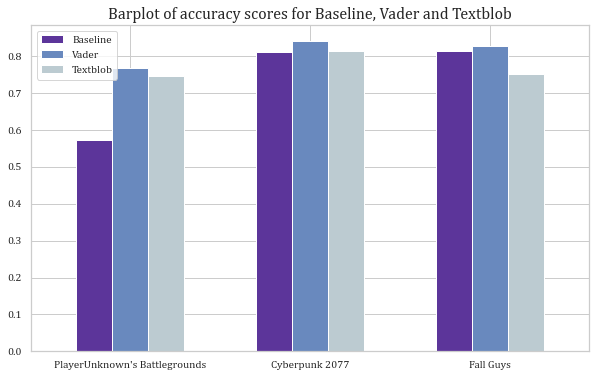

In [17]:
lexicon_df.plot.bar(figsize=(10, 6), width=0.6);

plt.title('Barplot of accuracy scores for Baseline, Vader and Textblob', fontsize=16)
plt.xticks(rotation=0);

- **PUBG**: Vader outperformed Textblob.
    - Both are better than the baseline accuracy score of 0.573


- **Cyberpunk**: Vader outperformed Textblob.
    - Vader is slightly better than the baseline accuracy score of 0.812
    - Textblob is equivalent to the baseline accuracy score
    

- **Fall Guys**: Vader outperformed Textblob.
    - Vader is very slightly better than the baseline accuracy score of 0.815
    - Textblob is worse than the baseline accuracy score

From the classification matrices, we can see that Textblob tended to predict a larger number of False Negatives, while Vader consistently predicted more False Positives. Overall, Vader consistently outperforms Textblob, with slightly better than the baseline accuracy for each game. 

This is likely due to how it is better tuned for social media sentiment analysis, and accounts for the use of degree modifiers (intensifiers such as very, extremely), punctuation and capitalization. Empirically, Textblob tends to perform better with more formal text (e.g. movie reviews) instead.

The accuracy score may not be the best metric here given the rather imbalanced target variable for the case of Cyberpunk and Fall Guys. Nonetheless, this demonstrates how lexicon-based sentiment analysis methods can be applied to give a quick estimate of the overall sentiment of a consumer review.

# ML-based Sentiment Analysis

While lexicon-based methods are a quick and efficient way to conduct sentiment analysis (since they have already been trained extensively beforehand), they may not be wholly accurate and generalizable as each corpus may have its own unique characteristics (e.g. nature of language, specific slang). 

As such, we will also apply machine learning techniques to perform sentiment analysis in this section.

## Preprocessing

In [6]:
# read in datasets again, with _ml suffix

pubg_ml = pd.read_csv('datasets/pubg.csv')
cyberpunk_ml = pd.read_csv('datasets/cyberpunk.csv')
fallguys_ml = pd.read_csv('datasets/fallguys.csv')

In [19]:
# create dictionary of dataframes and names

dfs_ml = {"PlayerUnknown's Battlegrounds": pubg_ml, 
          "Cyberpunk 2077": cyberpunk_ml, 
          "Fall Guys": fallguys_ml
         }

### Drop rows with `review_length` less than 10

In [83]:
# print number of rows for each dataset before and after dropping review_length < 10

for df_name, df in dfs_ml.items():
    
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(f'Number of rows before dropping: {df.shape[0]}')
    
    no_rows_initial = df.shape[0]
    
    df.drop(df[df['review_length'] < 10].index, inplace=True)
    print(f'Number of rows after dropping: {df.shape[0]}')
    
    no_rows_final = df.shape[0]
    
    print(f'Rows dropped: {no_rows_initial - no_rows_final}')
    print(' ')

-------
PlayerUnknown's Battlegrounds
-------
Number of rows before dropping: 227901
Number of rows after dropping: 156905
Rows dropped: 70996
 
-------
Cyberpunk 2077
-------
Number of rows before dropping: 75663
Number of rows after dropping: 58210
Rows dropped: 17453
 
-------
Fall Guys
-------
Number of rows before dropping: 78990
Number of rows after dropping: 46262
Rows dropped: 32728
 


### Stopword removal and lemmatization

In [84]:
# define stop words

stopword_set = set(nltk_stopwords.words('english'))
stopwords_to_remove = ['aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'don', "don't", 
                       'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
                       'more', 'most', 'no', 'nor', 'not', 'only', 'should', "should've", 'shouldn',
                       "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# add single letter characters, which are typical of memes/spam
stopwords_to_add = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

for stopword in stopwords_to_remove:
    stopword_set.discard(stopword)
    
for stopword in stopwords_to_add:
    stopword_set.add(stopword)

In [85]:
# define a function to obtain the part of speech tag of our text

def get_wordnet_pos(word):
    
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    # return NOUN if the tag cannot be found
    return tag_dict.get(tag, wordnet.NOUN)

In [86]:
# define a function for lemmatization and stop word removal

def stopword_lemmatizer(text, lemmatizer):
    """
    Removes stop words, and then lemmatizes a text string based on its POS tag. 
    """
    meaningful_words = ' '.join([word for word in text.split() if word not in stopword_set])
    lemmed_words = ' '.join(map(lambda x: lemmatizer.lemmatize(x, get_wordnet_pos(x)), meaningful_words.split()))
    
    return lemmed_words

In [87]:
# initialize lemmatizer

lemma = WordNetLemmatizer()

In [88]:
# lemmatize the clean_text in the dataframes - takes a long time

for df_name, df in dfs_ml.items():
    
    print('-------')
    print(f'Lemmatizing dataset for {df_name}...')
    df['lemmed_text'] = df['clean_text'].apply(stopword_lemmatizer, lemmatizer=lemma)
    print(f'Lemmatization for {df_name} complete.')
    print('-------')
    print('')

-------
Lemmatizing dataset for PlayerUnknown's Battlegrounds...
Lemmatization for PlayerUnknown's Battlegrounds complete.
-------

-------
Lemmatizing dataset for Cyberpunk 2077...
Lemmatization for Cyberpunk 2077 complete.
-------

-------
Lemmatizing dataset for Fall Guys...
Lemmatization for Fall Guys complete.
-------



In [90]:
# define a function to obtain the length of the lemmed_text

def lem_review_length(text):
    try:
        return len(text.split())
    except:
        return 0

In [91]:
# obtain length of lemmed text

for df in dfs_ml.values():
    df['lemmed_review_length'] = df['lemmed_text'].apply(lem_review_length)

### Drop rows with `lemmed_review_length` less than 10

In [93]:
# print number of rows for each dataset before and after dropping lemmed_review_length < 10

for df_name, df in dfs_ml.items():
    
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(f'Number of rows before dropping: {df.shape[0]}')
    
    no_rows_initial = df.shape[0]
    
    df.drop(df[df['lemmed_review_length'] < 10].index, inplace=True)
    print(f'Number of rows after dropping: {df.shape[0]}')
    
    no_rows_final = df.shape[0]
    
    print(f'Rows dropped: {no_rows_initial - no_rows_final}')

-------
PlayerUnknown's Battlegrounds
-------
Number of rows before dropping: 156905
Number of rows after dropping: 123254
Rows dropped: 33651
-------
Cyberpunk 2077
-------
Number of rows before dropping: 58210
Number of rows after dropping: 47619
Rows dropped: 10591
-------
Fall Guys
-------
Number of rows before dropping: 46262
Number of rows after dropping: 31520
Rows dropped: 14742


### Drop rows that mainly comprise spam


In [94]:
# define a function to mark reviews which are likely to be spam

def spam_detector(text):
    
    split_text = text.split()
    
    # find all the unique words in the lemmed_words column
    unique_words = set(split_text)
    
    for word in unique_words:
        
        # expect the term 'game' to crop up multiple times
        if word == 'game': 
            continue
            
        word_count = split_text.count(word)
        
        # we mark the review as spam only if it contains more than 20 instances of the same word
        if word_count > 20:
            return 1
        
    else:
        return 0

In [95]:
# print number of rows for each dataset before and after dropping spam reviews

for df_name, df in dfs_ml.items():
    
    print('-------')
    print(f'{df_name}')
    print('-------')
    print(f'Number of rows before dropping: {df.shape[0]}')
    
    no_rows_initial = df.shape[0]
    df['spam_detected'] = df['lemmed_text'].apply(spam_detector)
    df.drop(df[df['spam_detected'] == 1].index, inplace=True)
    print(f'Number of rows after dropping: {df.shape[0]}')
    
    no_rows_final = df.shape[0]
    
    print(f'Rows dropped: {no_rows_initial - no_rows_final}')

-------
PlayerUnknown's Battlegrounds
-------
Number of rows before dropping: 123254
Number of rows after dropping: 123058
Rows dropped: 196
-------
Cyberpunk 2077
-------
Number of rows before dropping: 47619
Number of rows after dropping: 47583
Rows dropped: 36
-------
Fall Guys
-------
Number of rows before dropping: 31520
Number of rows after dropping: 31490
Rows dropped: 30


A great deal of cleaning was required for the dataset, given that the typical Steam review section is populated with a lot of random noise - ranging from random ASCII art, memes, to repeated 'copypastas' that have no relevance to the game whatsoever. Unfortunately, the above cleaning steps are not sufficient to eliminate all of the aforementioned noise. Nonetheless, we will proceed with the subsequent modelling.

### Export to new .csv files

In [96]:
pubg_ml.to_csv('datasets/pubgcleaned.csv')
cyberpunk_ml.to_csv('datasets/cyberpunkcleaned.csv')
fallguys_ml.to_csv('datasets/fallguyscleaned.csv')

### Preparation of train and test datasets

In [20]:
# columns to be kept

cols_to_keep = ['review', 'lemmed_text', 'label']

In [21]:
# create new dataframes with only columns of interest

pubg_df_ml = pubg_ml[cols_to_keep].copy()
cyberpunk_df_ml = cyberpunk_ml[cols_to_keep].copy()
fallguys_df_ml = fallguys_ml[cols_to_keep].copy()

## PUBG

In [22]:
X_pubg = pubg_df_ml['lemmed_text']
y_pubg = pubg_df_ml['label']

In [23]:
y_pubg.value_counts(normalize=True)

0    0.534894
1    0.465106
Name: label, dtype: float64

Our baseline accuracy is **0.535**.

In [24]:
# create training and test sets

X_pubg_train, X_pubg_test, y_pubg_train, y_pubg_test = train_test_split(X_pubg,
                                                                        y_pubg,
                                                                        test_size=0.25,
                                                                        stratify=y_pubg,
                                                                        random_state=42)

### Logistic Regression

In [25]:
# set up pipeline for LogisticRegression

pipe_pubg_lr = Pipeline([
                ('tvec', TfidfVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             )),
                ('lr', SGDClassifier(loss='log', penalty='l2'))
])

In [26]:
# set up parameter grid for our pipe_lr

pipe_pubg_lr_params = {
                    'tvec__max_features': [10000], # [10000, 20000, 30000, 40000]
                    'tvec__min_df': [10], # [5, 10]
                    'tvec__max_df': [0.70], # [0.30, 0.50, 0.70]
                    'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                    'lr__alpha': [0.0001] # [0.0001, 0.001, 0.01]
}

In [27]:
# instantiate GridSearchCV

gs_pubg_lr = GridSearchCV(pipe_pubg_lr, 
                          param_grid=pipe_pubg_lr_params,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [28]:
# search through the parameter grid using GridSearchCV

gs_pubg_lr.fit(X_pubg_train, y_pubg_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.3s remaining:   32.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', SGDClassifier(loss='log'))]),
             n_jobs=-1,
             param_grid={'lr__alpha': [0.0001], 'tvec__max_df': [0.7],
                         'tvec__max_features': [10000], 'tvec__min_df': [10],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='roc_auc', verbose=1)

In [29]:
def gridsearch_model(gs):
    """
    Takes in a fitted GridSearchCV object as input and prints the best score, best parameters and returns the best
    estimator.
    """
    print('--------')
    print(f'Best mean cross-validated ROC-AUC score: {gs.best_score_:.4f}')
    print('--------')
    print('Best parameters:')
    display(gs.best_params_)
    model = gs.best_estimator_
    
    return model

In [30]:
# print out gridsearch info for LogReg and save our LogisticRegression model

pubg_lr_model = gridsearch_model(gs_pubg_lr)

--------
Best mean cross-validated ROC-AUC score: 0.9271
--------
Best parameters:


{'lr__alpha': 0.0001,
 'tvec__max_df': 0.7,
 'tvec__max_features': 10000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [31]:
# fit LogisticRegression model

pubg_lr_model.fit(X_pubg_train, y_pubg_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=10000, min_df=10,
                                 ngram_range=(1, 2))),
                ('lr', SGDClassifier(loss='log'))])

In [125]:
# define a function to plot the ROC-AUC curve, relevant metrics and also the confusion matrix

def plot_matrix_rocauc_metrics(model, model_name, X_train, X_test, y_train, y_test):
    """
    Combines the plot_confusion_matrix and plot_roc_curve functions from the sklearn library into one function.
    """
    print('--------')
    print(f'Classification Report for {model_name} model:')
    print('--------')
    print(classification_report(y_test, model.predict(X_test)))
    print('--------')
    print(f'Results for {model_name} model:')
    print('--------')
    print('')
    print(f'Accuracy score on train data ---: {model.score(X_train, y_train):.4f}')
    print(f'Accuracy score on test data ----: {model.score(X_test, y_test):.4f}')
        
    if model_name == 'Support Vector Classifier':
        plot_confusion_matrix(model, X_test, y_test, cmap='cividis')
        plt.grid(False)
    
    else:
        print(f'ROC-AUC score on train data ----: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]):.4f}')
        print(f'ROC-AUC score on test data -----: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}')                                                           

        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
        plot_confusion_matrix(model, X_test, y_test, cmap='cividis', ax=ax[0])
        ax[0].grid(False)
    
        plot_roc_curve(model, X_test, y_test, c='midnightblue', ax=ax[1])

--------
Classification Report for Logistic Regression model:
--------
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     16456
           1       0.86      0.82      0.84     14309

    accuracy                           0.86     30765
   macro avg       0.86      0.85      0.85     30765
weighted avg       0.86      0.86      0.86     30765

--------
Results for Logistic Regression model:
--------

Accuracy score on train data ---: 0.8611
Accuracy score on test data ----: 0.8556
ROC-AUC score on train data ----: 0.9332
ROC-AUC score on test data -----: 0.9267


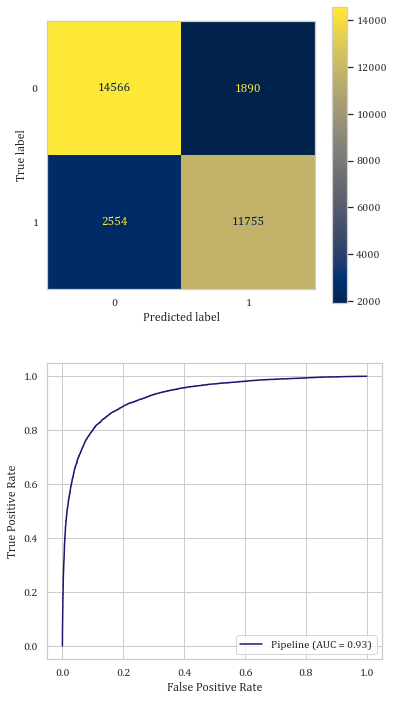

In [126]:
# print results for LogisticRegression model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(pubg_lr_model, 'Logistic Regression', X_pubg_train, X_pubg_test, y_pubg_train, y_pubg_test)

In [34]:
# obtain feature names from the individual steps of the pipeline

pubg_lr_feature_names = pubg_lr_model.steps[0][1].get_feature_names()

In [35]:
# obtain feature coefficients from the individual steps of the pipeline

pubg_lr_coef = pubg_lr_model.steps[1][1].coef_[0]

In [36]:
# combine into a DataFrame

pubg_feature_df = pd.DataFrame(data={'Feature': pubg_lr_feature_names, 
                                     'Coefficient': pubg_lr_coef,
                                     'Exponent of Coefficient': np.exp(pubg_lr_coef)})

In [37]:
# sort by the magnitude and display the top 30 values

pubg_lr_top30 = pubg_feature_df.sort_values(by='Coefficient', key=abs, ascending=False).head(30)
pubg_lr_top30

,Feature,Coefficient,Exponent of Coefficient
924,best,4.395475,81.083130
5780,money,-4.271037,0.013967
4125,great,4.199626,66.661367
751,bad,-3.791824,0.022554
4030,good,3.593667,36.367172
3088,fun,3.540432,34.481802
6213,not,-3.510506,0.029882
5374,love,3.318457,27.617699
1352,cheater,-3.212384,0.040261
6343,not worth,-3.162169,0.042334


The coefficients of a Logistic Regression model are easily interpretable. For example, a one unit increase in the Tf-idf vector for 'best' would mean that the post is $e^{4.394512} = 81$  times more likely to be a positive review.

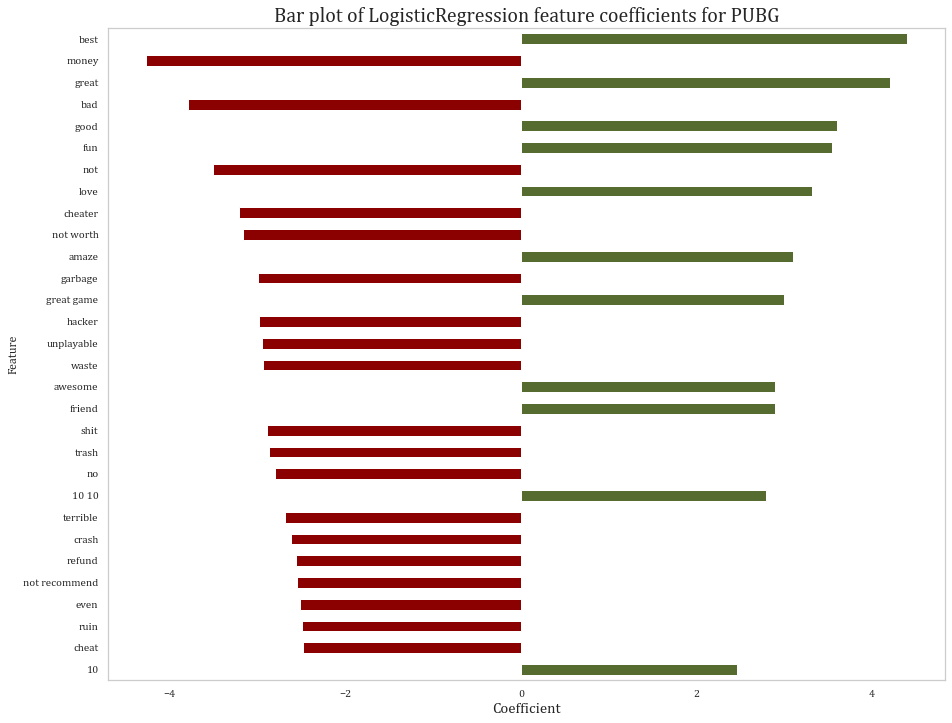

In [38]:
# display in a bar plot

pubg_lr_top30.plot(x='Feature', y='Coefficient', kind='barh', figsize=(15, 12), width=0.5,
                   color=(pubg_lr_top30['Coefficient'] >= 0).map({True: 'darkolivegreen', False: 'darkred'}),
                   legend=False)
                                                             
plt.title('Bar plot of LogisticRegression feature coefficients for PUBG', fontsize=20)
plt.xlabel('Coefficient', fontsize=15)
plt.gca().invert_yaxis();
plt.grid(False)

### Naive Bayes Classifier

In [39]:
# set up pipeline for MultinomialNB
# MultinomialNB is used even though the inputs are not integer counts; works with tf-idf vectors

pipe_pubg_nb = Pipeline([
    ('tvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None
                             )),
    ('nb', MultinomialNB())
])

In [40]:
# set up parameter grid for our pipe_nb

pipe_pubg_nb_params = {
                    'tvec__max_features': [40000], # [10000, 20000, 30000, 40000]
                    'tvec__min_df': [5], # [5, 10]
                    'tvec__max_df': [0.50], # [0.30, 0.50, 0.70]
                    'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                    'nb__alpha': [1] # [0.1, 0.5, 1]
}

In [41]:
# instantiate GridSearchCV

gs_pubg_nb = GridSearchCV(pipe_pubg_nb,
                          param_grid=pipe_pubg_nb_params,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [42]:
# search through the parameter grid using GridSearchCV

gs_pubg_nb.fit(X_pubg_train, y_pubg_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1], 'tvec__max_df': [0.5],
                         'tvec__max_features': [40000], 'tvec__min_df': [5],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='roc_auc', verbose=1)

In [43]:
# print out gridsearch info for Naive Bayes and save our MultinomialNB model

pubg_nb_model = gridsearch_model(gs_pubg_nb)

--------
Best mean cross-validated ROC-AUC score: 0.9249
--------
Best parameters:


{'nb__alpha': 1,
 'tvec__max_df': 0.5,
 'tvec__max_features': 40000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [44]:
# fit MultinomialNB model

pubg_nb_model.fit(X_pubg_train, y_pubg_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.5, max_features=40000, min_df=5,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=1))])

--------
Classification Report for Naive Bayes Classifier model:
--------
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     16456
           1       0.87      0.81      0.84     14309

    accuracy                           0.85     30765
   macro avg       0.86      0.85      0.85     30765
weighted avg       0.86      0.85      0.85     30765

--------
Results for Naive Bayes Classifier model:
--------

Accuracy score on train data ---: 0.8729
Accuracy score on test data ----: 0.8548
ROC-AUC score on train data ----: 0.9417
ROC-AUC score on test data -----: 0.9255


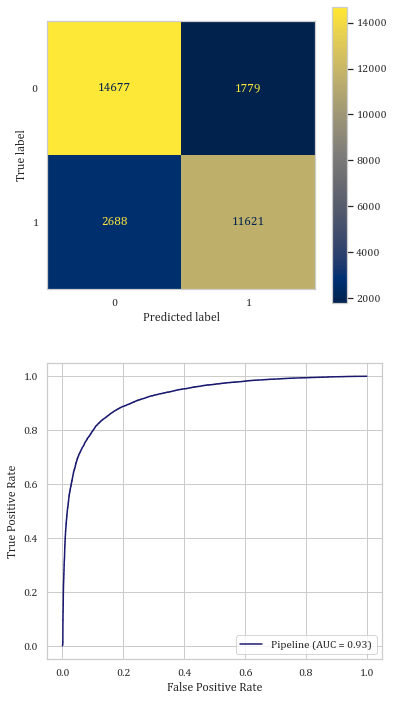

In [127]:
# print results for MultinomialNB model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(pubg_nb_model, 'Naive Bayes Classifier', X_pubg_train, X_pubg_test, y_pubg_train, y_pubg_test)

In [46]:
# extract probabilities for positive class
pubg_nb_pos_class_prob_sorted = pubg_nb_model.steps[1][1].feature_log_prob_[1, :].argsort()

# extract probabilities for negative class
pubg_nb_neg_class_prob_sorted = pubg_nb_model.steps[1][1].feature_log_prob_[0, :].argsort()

# getting the features for each class
pubg_nb_pos_top_features = np.take(pubg_nb_model.steps[0][1].get_feature_names(), pubg_nb_pos_class_prob_sorted)
pubg_nb_neg_top_features = np.take(pubg_nb_model.steps[0][1].get_feature_names(), pubg_nb_neg_class_prob_sorted)

In [47]:
# put together in a DataFrame for the positive class

pd.DataFrame(data={'Positive Class Features': pubg_nb_pos_top_features[-10:], 'NB Coefficient': sorted(pubg_nb_model.steps[1][1].feature_log_prob_[1, :])[-10:]})

,Positive Class Features,NB Coefficient
0,not,-6.117153
1,friend,-6.069751
2,well,-6.043985
3,like,-5.983379
4,great,-5.950455
5,10,-5.832794
6,good,-5.766152
7,get,-5.685988
8,fun,-5.654488
9,play,-5.577748


In [48]:
# put together in a DataFrame for the negative class

pd.DataFrame(data={'Negative Class Features': pubg_nb_neg_top_features[-10:], 'NB Coefficient': sorted(pubg_nb_model.steps[1][1].feature_log_prob_[0, :])[-10:]})

,Negative Class Features,NB Coefficient
0,no,-6.168136
1,time,-6.150581
2,fix,-6.148479
3,like,-6.127280
4,hacker,-6.095682
5,bad,-6.093661
6,server,-6.077956
7,play,-5.815865
8,get,-5.741718
9,not,-5.667952


The NB coefficient is evaluated as the log of the estimated probability of a feature given the respective class. The higher (less negative) the NB coefficients, the stronger the predictive strength of the feature.

For the positive class features, the most predictive features are 'play', 'fun', 'get'. 

For the negative class features, the most predictive features are 'not', 'get' and 'play'.

The top three features are not nearly as explanatory as those from Logistic Regression.

### Support Vector Classifier

In [49]:
# set up pipeline for SVC

pipe_pubg_svc = Pipeline([
    ('tvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None
                             )),
    ('svc', SGDClassifier(loss='hinge', penalty='l2'))
])

In [50]:
# set up parameter grid for our pipe_svc

pipe_pubg_svc_params = {
                    'tvec__max_features': [20000], # [10000, 20000]
                    'tvec__min_df': [10], # [5, 10] 
                    'tvec__max_df': [0.70], # [0.30, 0.50, 0.70]
                    'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                    'svc__alpha': [0.0001]
}

In [51]:
# instantiate GridSearchCV

gs_pubg_svc = GridSearchCV(pipe_pubg_svc,
                          param_grid=pipe_pubg_svc_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [52]:
# search through the parameter grid using GridSearchCV

gs_pubg_svc.fit(X_pubg_train, y_pubg_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.1s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'svc__alpha': [0.0001], 'tvec__max_df': [0.7],
                         'tvec__max_features': [20000], 'tvec__min_df': [10],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='accuracy', verbose=1)

In [53]:
# print out gridsearch info for Support Vector Classifier and save our SVC model

pubg_svc_model = gridsearch_model(gs_pubg_svc)

--------
Best mean cross-validated ROC-AUC score: 0.8622
--------
Best parameters:


{'svc__alpha': 0.0001,
 'tvec__max_df': 0.7,
 'tvec__max_features': 20000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [54]:
# fit SVC model

pubg_svc_model.fit(X_pubg_train, y_pubg_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=20000, min_df=10,
                                 ngram_range=(1, 2))),
                ('svc', SGDClassifier())])

--------
Classification Report for Support Vector Classifier model:
--------
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     16456
           1       0.87      0.83      0.85     14309

    accuracy                           0.86     30765
   macro avg       0.87      0.86      0.86     30765
weighted avg       0.86      0.86      0.86     30765

--------
Results for Support Vector Classifier model:
--------

Accuracy score on train data ---: 0.8778
Accuracy score on test data ----: 0.8646


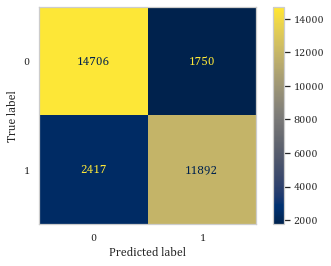

In [128]:
# print results for SVC model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(pubg_svc_model, 'Support Vector Classifier', X_pubg_train, X_pubg_test, y_pubg_train, y_pubg_test)

SVC has its downsides as it is somewhat of a 'blackbox' model, and is not easily interpretable.

### LSTM

Long Short Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) designed to overcome the problems of simple RNNs, by allowing the network to store data in a form of memory, that it can access at a later times. This allows them to learn long-term dependencies.

The codes for LSTM were run in Google Colaboratory to maximize the use of the GPU for efficient training (**02a_LSTM.ipynb**).

In [115]:
def lstm_tokenizer(X, max_review_length, vocab_length):
    """
    Vectorizes a text corpus by tokenizing and padding a series of texts to the 
    desired length to form a data tensor.
    """

    # set max vocabulary of tokenizer
    tokenizer = Tokenizer(num_words=vocab_length,
                          filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                          lower=True
                         )

    # fit tokenizer on lists of texts; every entry of each list is taken to be a token
    tokenizer.fit_on_texts(X)

    # transforms each text in texts to a sequence of integers
    X_lstm = tokenizer.texts_to_sequences(X)

    # pad each text to be the same as max_review_length
    X_lstm = sequence.pad_sequences(X_lstm, maxlen=max_review_length)

    print('Shape of data tensor:', X_lstm.shape)

    return X_lstm

In [ ]:
X_pubg_lstm = lstm_tokenizer(X_pubg, 200, 20000)

In [ ]:
y_pubg_lstm = pd.get_dummies(y_pubg).values[:, 1]

In [ ]:
def lstm_train_test_split(X_lstm, y_lstm, y, split_frac):

    """
    Split data tensor into training and testing sets.
    """

    # split data into training, validation, and test data (features and labels, x and y)
    np.random.seed(42)

    # calculate total number of reviews in training and test set
    train_count = int(len(X_lstm) * split_frac)
    test_count = len(X_lstm) - train_count

    # obtain number of positive and negative reviews in test set
    test_negative_count = int(y.value_counts(normalize=True)[0] * test_count)
    test_positive_count = test_count - test_negative_count

    # randomly select the training and test indices 
    test_inds = np.append(np.random.choice(np.where(y_lstm == 0)[0], test_negative_count, replace=False), 
                          np.random.choice(np.where(y_lstm == 1)[0], test_positive_count, replace=False))

    train_inds = list(set(range(len(y))) - set(test_inds))

    # obtain data and corresponding labels
    train_data = X_lstm[train_inds]
    train_labels = y_lstm[train_inds]

    test_data = X_lstm[test_inds]
    test_labels = y_lstm[test_inds]

    return train_data, train_labels, test_data, test_labels

In [ ]:
# create training and testing sets for lstm

X_pubg_train_lstm, y_pubg_train_lstm, X_pubg_test_lstm, y_pubg_test_lstm = lstm_train_test_split(X_pubg_lstm, y_pubg_lstm, y_pubg, 0.25)

In [ ]:
# define function to create lstm models

def create_lstm_model(X_lstm, input_dim, embedding_dim):
    
    """
    Create a LSTM model to be used for binary classification.
    """
    model = Sequential()
    model.add(Embedding(input_dim, embedding_dim, input_length=X_lstm.shape[1]))
    model.add(SpatialDropout1D(0.5))
    model.add(LSTM(256, dropout=0.5, activation='tanh', return_sequences=True))
    model.add(LSTM(128, dropout=0.5, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())

    return model

In [ ]:
# create lstm model

pubg_lstm_model = create_lstm_model(X_pubg_lstm, 20000, 200)

In [ ]:
# define a function to create a class_weights dictionary for an imbalanced binary dataset

def generate_class_weights(y):

    class_weights = {}

    if y.value_counts()[0] == y.value_counts()[1]:
        majority_class = 1
        minority_class = 0
        majority_class_weight = minority_class_weight = 1
               
    else:
        majority_class = y.value_counts(normalize=True).idxmax()
        minority_class = y.value_counts(normalize=True).idxmin()

        majority_class_weight = 1
        minority_class_weight = y.value_counts()[majority_class] / y.value_counts()[minority_class]

    class_weights[majority_class] = majority_class_weight
    class_weights[minority_class] = minority_class_weight

    return class_weights

In [ ]:
pubg_class_weights = generate_class_weights(y_pubg)

In [ ]:
def lstm_model_fit_evaluate(lstm_model, train_data, train_labels, test_data, test_labels, class_weights, epochs=5, batch_size=50):
    
    """
    Fit and evaluate LSTM model. Return the training history and loss and accuracy 
    on the test set.
    """

    history = lstm_model.fit(train_data, train_labels,
                             class_weight=class_weights, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             validation_split=0.1)

    loss, acc = lstm_model.evaluate(test_data, test_labels, 
                                    verbose=2,
                                    batch_size=batch_size)

    print('')
    print(f"Loss ------------------: {loss:.4f}")
    print(f"Validation accuracy ---: {acc:.4f}")

    return history, loss, acc

In [ ]:
pubg_history, pubg_loss, pubg_acc = lstm_model_fit_evaluate(pubg_lstm_model,
                                                            X_pubg_train_lstm, 
                                                            y_pubg_train_lstm, 
                                                            X_pubg_test_lstm, 
                                                            y_pubg_test_lstm,
                                                            class_weights = pubg_class_weights,
                                                            epochs=5,
                                                            batch_size=50)

In [ ]:
# define function to plot the corresponding metrics with number of epochs

def plot_history_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("No. of epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
def lstm_metrics_plot(lstm_model, history, test_data, test_labels):
    
    # generate predicted probabilities for test data
    test_predict_proba = lstm_model.predict(test_data)
    test_predict_proba_full = np.concatenate((1 - test_predict_proba, test_predict_proba), axis=1)

    # obtain ROC-AUC score on test data
    auc_score = roc_auc_score(test_labels, test_predict_proba_full[:, 1])

    # generate predictions for test data
    test_pred = (test_predict_proba_full > 0.5).astype("int32")

    # obtain f1-score on test data
    f1 = f1_score(test_labels, test_pred[:, 1])

    print(f'ROC-AUC score ------: {auc_score:.4f}')
    print(f'F1-score -----------: {f1:.4f}')

    # plot val accuracy and val loss graphs
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plot_history_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_history_graphs(history, 'loss')

In [ ]:
lstm_metrics_plot(pubg_lstm_model, pubg_history, X_pubg_test_lstm, y_pubg_test_lstm)

In [ ]:
# create final lstm model

pubg_lstm_model_final = create_lstm_model(X_pubg_lstm, 20000, 200)

In [ ]:
pubg_history, pubg_loss, pubg_acc = lstm_model_fit_evaluate(pubg_lstm_model_final,
                                                            X_pubg_train_lstm, 
                                                            y_pubg_train_lstm, 
                                                            X_pubg_test_lstm, 
                                                            y_pubg_test_lstm,
                                                            class_weights = pubg_class_weights,
                                                            epochs=2,
                                                            batch_size=50)

In [ ]:
lstm_metrics_plot(pubg_lstm_model_final, pubg_history, X_pubg_test_lstm, y_pubg_test_lstm)

**Training Epochs**

![Results for PUBG - LSTM](./results/lstm_pubg_epochs.png)

**Final ROC-AUC and Accuracy Scores**

![Results for PUBG - LSTM](./results/lstm_pubg.png)

## Cyberpunk

In [56]:
X_cyberpunk = cyberpunk_df_ml['lemmed_text']
y_cyberpunk = cyberpunk_df_ml['label']

In [57]:
y_cyberpunk.value_counts(normalize=True)

1    0.735914
0    0.264086
Name: label, dtype: float64

Our baseline accuracy is **0.736**. While it is possible to use sampling methods such as Synthetic Minority Over-sampling Technique (SMOTE) to create new synthetic samples from the minority class, this approach normally does not work well with text data due to the high-dimensional nature of the numerical vectors created.

In [58]:
# create training and test sets

X_cyberpunk_train, X_cyberpunk_test, y_cyberpunk_train, y_cyberpunk_test = train_test_split(X_cyberpunk,
                                                                        y_cyberpunk,
                                                                        test_size=0.25,
                                                                        stratify=y_cyberpunk,
                                                                        random_state=42)

### Logistic Regression

In [59]:
# set up pipeline for LogisticRegression

pipe_cyberpunk_lr = Pipeline([
                ('tvec', TfidfVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             )),
                ('lr', SGDClassifier(loss='log', penalty='l2'))
])

In [60]:
# set up parameter grid for our pipe_lr

pipe_cyberpunk_lr_params = {
                        'tvec__max_features': [10000], # [10000, 20000, 30000, 40000]
                        'tvec__min_df': [5], # [5, 10]
                        'tvec__max_df': [0.30], # [0.30, 0.50, 0.70]
                        'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                        'lr__alpha': [0.0001]
}

In [61]:
# instantiate GridSearchCV

gs_cyberpunk_lr = GridSearchCV(pipe_cyberpunk_lr, 
                          param_grid=pipe_cyberpunk_lr_params,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [62]:
# search through the parameter grid using GridSearchCV

gs_cyberpunk_lr.fit(X_cyberpunk_train, y_cyberpunk_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', SGDClassifier(loss='log'))]),
             n_jobs=-1,
             param_grid={'lr__alpha': [0.0001], 'tvec__max_df': [0.3],
                         'tvec__max_features': [10000], 'tvec__min_df': [5],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='roc_auc', verbose=1)

In [63]:
# print out gridsearch info for LogReg and save our LogisticRegression model

cyberpunk_lr_model = gridsearch_model(gs_cyberpunk_lr)

--------
Best mean cross-validated ROC-AUC score: 0.9568
--------
Best parameters:


{'lr__alpha': 0.0001,
 'tvec__max_df': 0.3,
 'tvec__max_features': 10000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [64]:
# fit LogisticRegression model

cyberpunk_lr_model.fit(X_cyberpunk_train, y_cyberpunk_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=10000, min_df=5,
                                 ngram_range=(1, 2))),
                ('lr', SGDClassifier(loss='log'))])

--------
Classification Report for Logistic Regression model:
--------
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      3142
           1       0.89      0.97      0.93      8754

    accuracy                           0.89     11896
   macro avg       0.90      0.82      0.85     11896
weighted avg       0.89      0.89      0.89     11896

--------
Results for Logistic Regression model:
--------

Accuracy score on train data ---: 0.9045
Accuracy score on test data ----: 0.8941
ROC-AUC score on train data ----: 0.9677
ROC-AUC score on test data -----: 0.9579


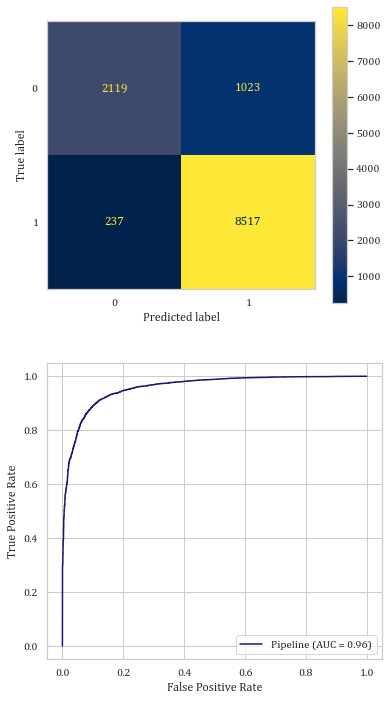

In [129]:
# print results for LogisticRegression model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(cyberpunk_lr_model, 'Logistic Regression', X_cyberpunk_train, X_cyberpunk_test, y_cyberpunk_train, y_cyberpunk_test)

In [66]:
# obtain feature names from the individual steps of the pipeline

cyberpunk_lr_feature_names = cyberpunk_lr_model.steps[0][1].get_feature_names()

In [67]:
# obtain feature coefficients from the individual steps of the pipeline

cyberpunk_lr_coef = cyberpunk_lr_model.steps[1][1].coef_[0]

In [68]:
# combine into a DataFrame

cyberpunk_feature_df = pd.DataFrame(data={'Feature': cyberpunk_lr_feature_names, 
                                          'Coefficient': cyberpunk_lr_coef,
                                          'Exponent of Coefficient': np.exp(cyberpunk_lr_coef)})

In [69]:
# sort by the magnitude and display the top 30 values

cyberpunk_lr_top30 = cyberpunk_feature_df.sort_values(by='Coefficient', key=abs, ascending=False).head(30)
cyberpunk_lr_top30

,Feature,Coefficient,Exponent of Coefficient
7550,refund,-5.381603,0.004600
515,amaze,4.713091,111.395927
994,boring,-4.097435,0.016615
416,ai,-3.875186,0.020750
4229,great,3.840201,46.534829
5438,love,3.709452,40.831428
6363,not worth,-3.409779,0.033048
2931,far,3.324503,27.785195
3294,fun,3.292366,26.906462
5721,mess,-3.214334,0.040182


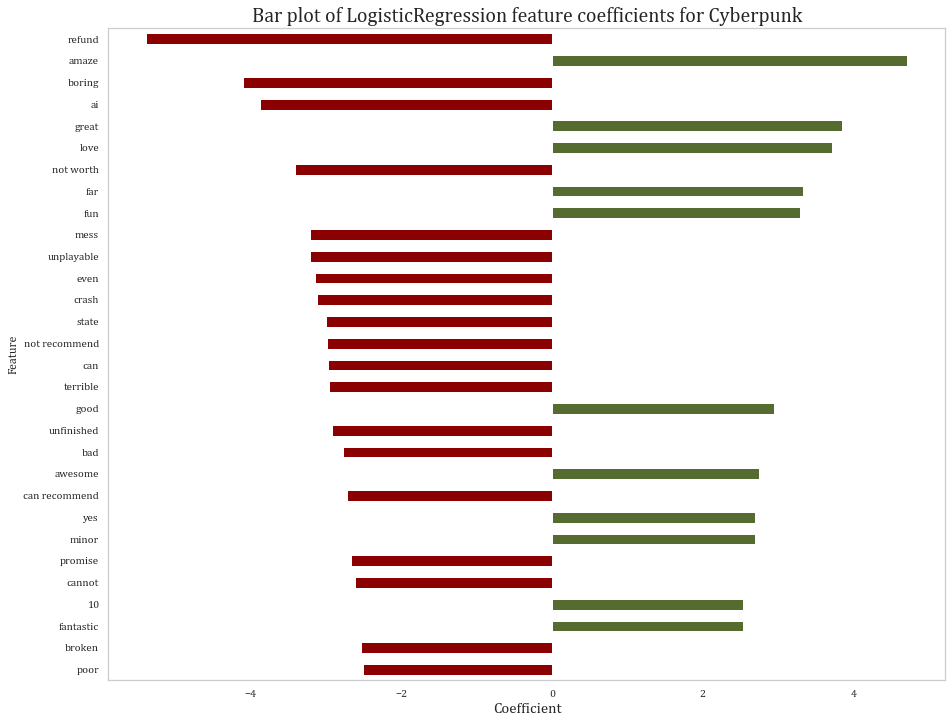

In [70]:
# display in a bar plot

cyberpunk_lr_top30.plot(x='Feature', y='Coefficient', kind='barh', figsize=(15, 12), width=0.5,
                   color=(cyberpunk_lr_top30['Coefficient'] >= 0).map({True: 'darkolivegreen', False: 'darkred'}),
                   legend=False)
                                                             
plt.title('Bar plot of LogisticRegression feature coefficients for Cyberpunk', fontsize=20)
plt.xlabel('Coefficient', fontsize=15)
plt.gca().invert_yaxis();
plt.grid(False)

### Naive Bayes Classifier

In [71]:
# set up pipeline for MultinomialNB
# MultinomialNB is used even though the inputs are not integer counts; works with tf-idf vectors

pipe_cyberpunk_nb = Pipeline([
    ('tvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None
                             )),
    ('nb', MultinomialNB())
])

In [72]:
# set up parameter grid for our pipe_nb

pipe_cyberpunk_nb_params = {
                    'tvec__max_features': [40000], # [10000, 20000, 30000, 40000]
                    'tvec__min_df': [5],
                    'tvec__max_df': [0.30],
                    'tvec__ngram_range': [(1, 2)],
                    'nb__alpha': [0.1]
}

In [73]:
# instantiate GridSearchCV

gs_cyberpunk_nb = GridSearchCV(pipe_cyberpunk_nb,
                          param_grid=pipe_cyberpunk_nb_params,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [74]:
# search through the parameter grid using GridSearchCV

gs_cyberpunk_nb.fit(X_cyberpunk_train, y_cyberpunk_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.1s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.1], 'tvec__max_df': [0.3],
                         'tvec__max_features': [40000], 'tvec__min_df': [5],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='roc_auc', verbose=1)

In [75]:
# print out gridsearch info for Naive Bayes and save our MultinomialNB model

cyberpunk_nb_model = gridsearch_model(gs_cyberpunk_nb)

--------
Best mean cross-validated ROC-AUC score: 0.9587
--------
Best parameters:


{'nb__alpha': 0.1,
 'tvec__max_df': 0.3,
 'tvec__max_features': 40000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [76]:
# fit MultinomialNB model

cyberpunk_nb_model.fit(X_cyberpunk_train, y_cyberpunk_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=40000, min_df=5,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.1))])

--------
Classification Report for Naive Bayes Classifier model:
--------
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      3142
           1       0.91      0.96      0.93      8754

    accuracy                           0.90     11896
   macro avg       0.88      0.84      0.86     11896
weighted avg       0.90      0.90      0.89     11896

--------
Results for Naive Bayes Classifier model:
--------

Accuracy score on train data ---: 0.9403
Accuracy score on test data ----: 0.8975
ROC-AUC score on train data ----: 0.9833
ROC-AUC score on test data -----: 0.9565


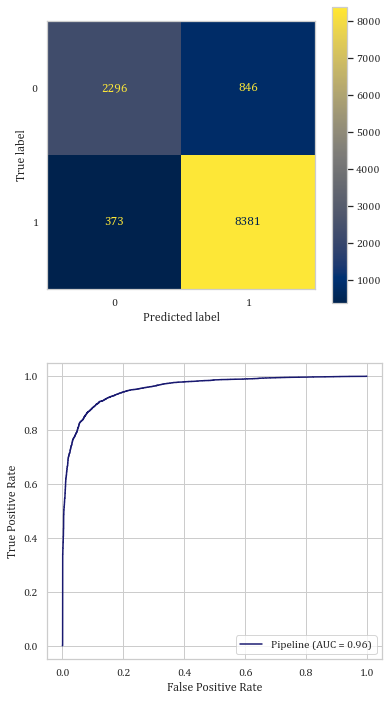

In [130]:
# print results for MultinomialNB model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(cyberpunk_nb_model, 'Naive Bayes Classifier', X_cyberpunk_train, X_cyberpunk_test, y_cyberpunk_train, y_cyberpunk_test)

In [78]:
# extract probabilities for positive class
cyberpunk_nb_pos_class_prob_sorted = cyberpunk_nb_model.steps[1][1].feature_log_prob_[1, :].argsort()

# extract probabilities for negative class
cyberpunk_nb_neg_class_prob_sorted = cyberpunk_nb_model.steps[1][1].feature_log_prob_[0, :].argsort()

# getting the features for each class
cyberpunk_nb_pos_top_features = np.take(cyberpunk_nb_model.steps[0][1].get_feature_names(), cyberpunk_nb_pos_class_prob_sorted)
cyberpunk_nb_neg_top_features = np.take(cyberpunk_nb_model.steps[0][1].get_feature_names(), cyberpunk_nb_neg_class_prob_sorted)

In [79]:
# put together in a DataFrame for the positive class

pd.DataFrame(data={'Positive Class Features': cyberpunk_nb_pos_top_features[-10:], 'NB Coefficient': sorted(cyberpunk_nb_model.steps[1][1].feature_log_prob_[1, :])[-10:]})

,Positive Class Features,NB Coefficient
0,run,-6.232118
1,amaze,-6.224113
2,fun,-6.186277
3,time,-6.177971
4,well,-6.163778
5,really,-6.129622
6,far,-6.109350
7,10,-5.962910
8,good,-5.879983
9,great,-5.877616


In [80]:
# put together in a DataFrame for the negative class

pd.DataFrame(data={'Negative Class Features': cyberpunk_nb_neg_top_features[-10:], 'NB Coefficient': sorted(cyberpunk_nb_model.steps[1][1].feature_log_prob_[0, :])[-10:]})

,Negative Class Features,NB Coefficient
0,year,-6.363894
1,bad,-6.336731
2,more,-6.329015
3,wait,-6.326142
4,fix,-6.316890
5,make,-6.304975
6,time,-6.242995
7,feel,-6.166320
8,no,-6.047209
9,even,-6.007562


### Support Vector Classifier

In [81]:
# set up pipeline for SVC

pipe_cyberpunk_svc = Pipeline([
    ('tvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None
                             )),
    ('svc', SGDClassifier(loss='hinge', penalty='l2'))
])

In [82]:
# set up parameter grid for our pipe_svc

pipe_cyberpunk_svc_params = {
                    'tvec__max_features': [20000], # [10000, 20000]
                    'tvec__min_df': [10], # [5, 10]
                    'tvec__max_df': [0.30], # [0.30, 0.50, 0.70]
                    'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                    'svc__alpha': [0.0001]
}

In [83]:
# instantiate GridSearchCV

gs_cyberpunk_svc = GridSearchCV(pipe_cyberpunk_svc,
                          param_grid=pipe_cyberpunk_svc_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [84]:
# search through the parameter grid using GridSearchCV

gs_cyberpunk_svc.fit(X_cyberpunk_train, y_cyberpunk_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'svc__alpha': [0.0001], 'tvec__max_df': [0.3],
                         'tvec__max_features': [20000], 'tvec__min_df': [10],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='accuracy', verbose=1)

In [85]:
# print out gridsearch info for Support Vector Classifier and save our SVC model

cyberpunk_svc_model = gridsearch_model(gs_cyberpunk_svc)

--------
Best mean cross-validated ROC-AUC score: 0.9088
--------
Best parameters:


{'svc__alpha': 0.0001,
 'tvec__max_df': 0.3,
 'tvec__max_features': 20000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [86]:
# fit SVC model

cyberpunk_svc_model.fit(X_cyberpunk_train, y_cyberpunk_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=20000, min_df=10,
                                 ngram_range=(1, 2))),
                ('svc', SGDClassifier())])

--------
Classification Report for Support Vector Classifier model:
--------
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      3142
           1       0.92      0.97      0.94      8754

    accuracy                           0.91     11896
   macro avg       0.90      0.86      0.88     11896
weighted avg       0.91      0.91      0.91     11896

--------
Results for Support Vector Classifier model:
--------

Accuracy score on train data ---: 0.9348
Accuracy score on test data ----: 0.9114


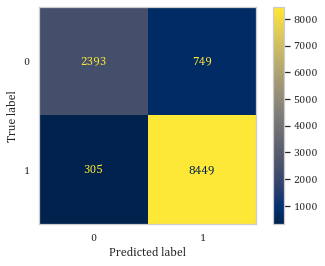

In [131]:
# print results for SVC model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(cyberpunk_svc_model, 'Support Vector Classifier', X_cyberpunk_train, X_cyberpunk_test, y_cyberpunk_train, y_cyberpunk_test)

### LSTM

In [ ]:
X_cyberpunk_lstm = lstm_tokenizer(X_cyberpunk, 200, 20000)

In [ ]:
y_cyberpunk_lstm = pd.get_dummies(y_cyberpunk).values[:, 1]

In [ ]:
# create training and testing sets for lstm

X_cyberpunk_train_lstm, y_cyberpunk_train_lstm, X_cyberpunk_test_lstm, y_cyberpunk_test_lstm = lstm_train_test_split(X_cyberpunk_lstm, 
                                                                                                                     y_cyberpunk_lstm, 
                                                                                                                     y_cyberpunk, 
                                                                                                                     0.25)

In [ ]:
# create lstm model

cyberpunk_lstm_model = create_lstm_model(X_cyberpunk_lstm, 20000, 200)

In [ ]:
cyberpunk_class_weights = generate_class_weights(y_cyberpunk)

In [ ]:
cyberpunk_history, cyberpunk_loss, cyberpunk_acc = lstm_model_fit_evaluate(cyberpunk_lstm_model,
                                                                           X_cyberpunk_train_lstm, 
                                                                           y_cyberpunk_train_lstm, 
                                                                           X_cyberpunk_test_lstm, 
                                                                           y_cyberpunk_test_lstm,
                                                                           class_weights = cyberpunk_class_weights,
                                                                           epochs=10,
                                                                           batch_size=50)

In [ ]:
lstm_metrics_plot(cyberpunk_lstm_model, cyberpunk_history, X_cyberpunk_test_lstm, y_cyberpunk_test_lstm)

In [ ]:
# create final lstm model

cyberpunk_lstm_model_final = create_lstm_model(X_cyberpunk_lstm, 20000, 200)

In [ ]:
cyberpunk_history, cyberpunk_loss, cyberpunk_acc = lstm_model_fit_evaluate(cyberpunk_lstm_model_final,
                                                                           X_cyberpunk_train_lstm, 
                                                                           y_cyberpunk_train_lstm, 
                                                                           X_cyberpunk_test_lstm, 
                                                                           y_cyberpunk_test_lstm,
                                                                           class_weights = cyberpunk_class_weights,
                                                                           epochs=4,
                                                                           batch_size=50)

In [ ]:
lstm_metrics_plot(cyberpunk_lstm_model_final, cyberpunk_history, X_cyberpunk_test_lstm, y_cyberpunk_test_lstm)

**Training Epochs**

![Results for Cyberpunk - LSTM](./results/lstm_cyberpunk_epochs.png)

**Final ROC-AUC and Accuracy Scores**

![Results for Cyberpunk - LSTM](./results/lstm_cyberpunk.png)

## Fall Guys

In [88]:
X_fallguys = fallguys_df_ml['lemmed_text']
y_fallguys = fallguys_df_ml['label']

In [89]:
y_fallguys.value_counts(normalize=True)

1    0.702159
0    0.297841
Name: label, dtype: float64

Our baseline accuracy is **0.702**. While it is possible to use sampling methods such as Synthetic Minority Over-sampling Technique (SMOTE) to create new synthetic samples from the minority class, this approach normally does not work well with text data due to the high-dimensional nature of the numerical vectors created.

In [90]:
# create training and test sets

X_fallguys_train, X_fallguys_test, y_fallguys_train, y_fallguys_test = train_test_split(X_fallguys,
                                                                        y_fallguys,
                                                                        test_size=0.25,
                                                                        stratify=y_fallguys,
                                                                        random_state=42)

### Logistic Regression

In [91]:
# set up pipeline for LogisticRegression

pipe_fallguys_lr = Pipeline([
                ('tvec', TfidfVectorizer(analyzer = 'word',
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             )),
                ('lr', SGDClassifier(loss='log', penalty='l2'))
])

In [92]:
# set up parameter grid for our pipe_lr

pipe_fallguys_lr_params = {
                        'tvec__max_features': [40000], # [10000, 20000, 30000, 40000]
                        'tvec__min_df': [10], # [5, 10]
                        'tvec__max_df': [0.70], # [0.30, 0.50, 0.70]
                        'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                        'lr__alpha': [0.0001] # [0.0001, 0.001, 0.01]
}

In [93]:
# instantiate GridSearchCV

gs_fallguys_lr = GridSearchCV(pipe_fallguys_lr, 
                          param_grid=pipe_fallguys_lr_params,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [94]:
# search through the parameter grid using GridSearchCV

gs_fallguys_lr.fit(X_fallguys_train, y_fallguys_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', SGDClassifier(loss='log'))]),
             n_jobs=-1,
             param_grid={'lr__alpha': [0.0001], 'tvec__max_df': [0.7],
                         'tvec__max_features': [40000], 'tvec__min_df': [10],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='roc_auc', verbose=1)

In [95]:
# print out gridsearch info for LogReg and save our LogisticRegression model

fallguys_lr_model = gridsearch_model(gs_fallguys_lr)

--------
Best mean cross-validated ROC-AUC score: 0.9414
--------
Best parameters:


{'lr__alpha': 0.0001,
 'tvec__max_df': 0.7,
 'tvec__max_features': 40000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [96]:
# fit LogisticRegression model

fallguys_lr_model.fit(X_fallguys_train, y_fallguys_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=40000, min_df=10,
                                 ngram_range=(1, 2))),
                ('lr', SGDClassifier(loss='log'))])

--------
Classification Report for Logistic Regression model:
--------
              precision    recall  f1-score   support

           0       0.85      0.68      0.75      2345
           1       0.87      0.95      0.91      5528

    accuracy                           0.87      7873
   macro avg       0.86      0.81      0.83      7873
weighted avg       0.87      0.87      0.86      7873

--------
Results for Logistic Regression model:
--------

Accuracy score on train data ---: 0.8940
Accuracy score on test data ----: 0.8668
ROC-AUC score on train data ----: 0.9605
ROC-AUC score on test data -----: 0.9364


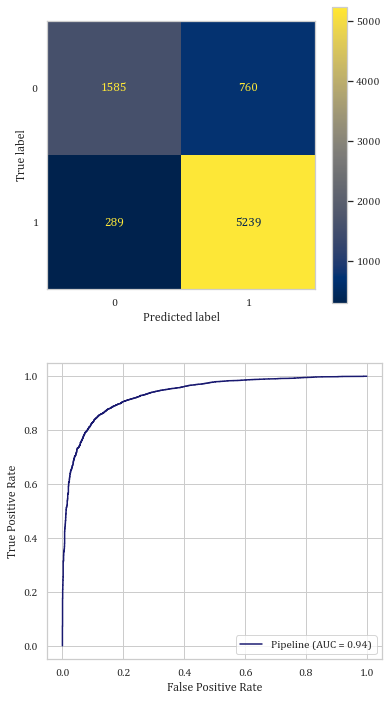

In [132]:
# print results for LogisticRegression model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(fallguys_lr_model, 'Logistic Regression', X_fallguys_train, X_fallguys_test, y_fallguys_train, y_fallguys_test)

In [98]:
# obtain feature names from the individual steps of the pipeline

fallguys_lr_feature_names = fallguys_lr_model.steps[0][1].get_feature_names()

In [99]:
# obtain feature coefficients from the individual steps of the pipeline

fallguys_lr_coef = fallguys_lr_model.steps[1][1].coef_[0]

In [100]:
# combine into a DataFrame

fallguys_feature_df = pd.DataFrame(data={'Feature': fallguys_lr_feature_names, 
                                         'Coefficient': fallguys_lr_coef,
                                         'Exponent of Coefficient': np.exp(fallguys_lr_coef)})

In [101]:
# sort by the magnitude and display the top 30 values

fallguys_lr_top30 = fallguys_feature_df.sort_values(by='Coefficient', key=abs, ascending=False).head(30)
fallguys_lr_top30

,Feature,Coefficient,Exponent of Coefficient
3603,fun,6.396395,599.679320
7813,not,-5.246723,0.005265
9540,refund,-4.513680,0.010958
5086,great,4.204423,66.981947
4949,good,3.966525,52.800724
7949,not worth,-3.829362,0.021723
1434,cheater,-3.605668,0.027169
7721,no,-3.382632,0.033958
919,best,3.308646,27.348073
5253,hacker,-3.305549,0.036679


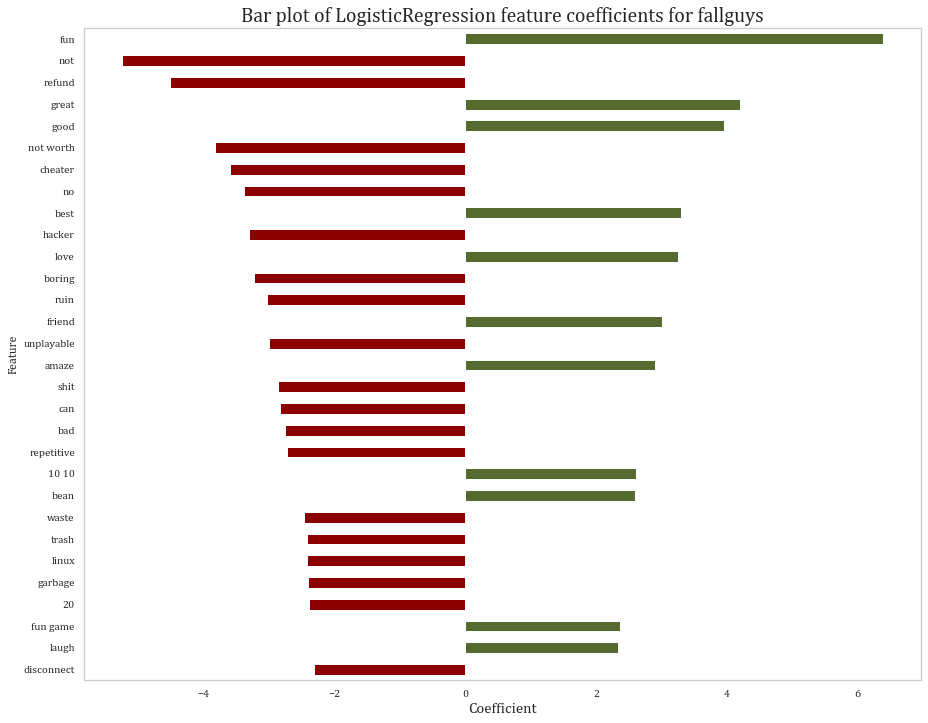

In [102]:
# display in a bar plot

fallguys_lr_top30.plot(x='Feature', y='Coefficient', kind='barh', figsize=(15, 12), width=0.5,
                   color=(fallguys_lr_top30['Coefficient'] >= 0).map({True: 'darkolivegreen', False: 'darkred'}),
                   legend=False)
                                                             
plt.title('Bar plot of LogisticRegression feature coefficients for fallguys', fontsize=20)
plt.xlabel('Coefficient', fontsize=15)
plt.gca().invert_yaxis();
plt.grid(False)

### Naive Bayes Classifier

In [103]:
# set up pipeline for MultinomialNB
# MultinomialNB is used even though the inputs are not integer counts; works with tf-idf vectors

pipe_fallguys_nb = Pipeline([
    ('tvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None
                             )),
    ('nb', MultinomialNB())
])

In [104]:
# set up parameter grid for our pipe_nb

pipe_fallguys_nb_params = {
                    'tvec__max_features': [20000], # [10000, 20000, 30000, 40000]
                    'tvec__min_df': [5], # [5, 10]
                    'tvec__max_df': [0.70], # [0.30, 0.50, 0.70]
                    'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                    'nb__alpha': [0.5] # [0.1, 0.5, 1]
}

In [105]:
# instantiate GridSearchCV

gs_fallguys_nb = GridSearchCV(pipe_fallguys_nb,
                          param_grid=pipe_fallguys_nb_params,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [106]:
# search through the parameter grid using GridSearchCV

gs_fallguys_nb.fit(X_fallguys_train, y_fallguys_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.5], 'tvec__max_df': [0.7],
                         'tvec__max_features': [20000], 'tvec__min_df': [5],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='roc_auc', verbose=1)

In [107]:
# print out gridsearch info for Naive Bayes and save our MultinomialNB model

fallguys_nb_model = gridsearch_model(gs_fallguys_nb)

--------
Best mean cross-validated ROC-AUC score: 0.9367
--------
Best parameters:


{'nb__alpha': 0.5,
 'tvec__max_df': 0.7,
 'tvec__max_features': 20000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [108]:
# fit MultinomialNB model

fallguys_nb_model.fit(X_fallguys_train, y_fallguys_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=20000, min_df=5,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.5))])

--------
Classification Report for Naive Bayes Classifier model:
--------
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2345
           1       0.88      0.93      0.91      5528

    accuracy                           0.87      7873
   macro avg       0.85      0.82      0.84      7873
weighted avg       0.87      0.87      0.86      7873

--------
Results for Naive Bayes Classifier model:
--------

Accuracy score on train data ---: 0.9107
Accuracy score on test data ----: 0.8676
ROC-AUC score on train data ----: 0.9662
ROC-AUC score on test data -----: 0.9333


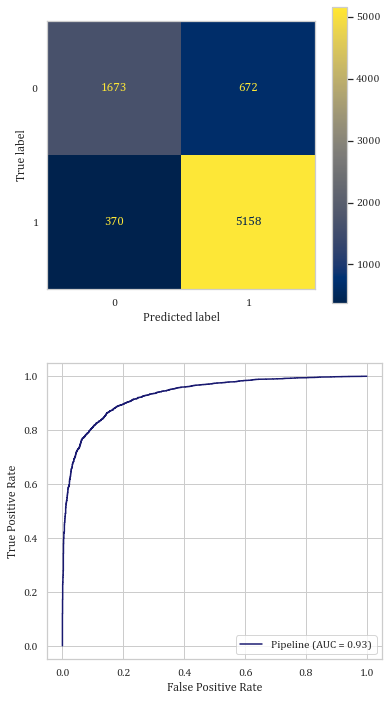

In [133]:
# print results for MultinomialNB model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(fallguys_nb_model, 'Naive Bayes Classifier', X_fallguys_train, X_fallguys_test, y_fallguys_train, y_fallguys_test)

In [110]:
# extract probabilities for positive class
fallguys_nb_pos_class_prob_sorted = fallguys_nb_model.steps[1][1].feature_log_prob_[1, :].argsort()

# extract probabilities for negative class
fallguys_nb_neg_class_prob_sorted = fallguys_nb_model.steps[1][1].feature_log_prob_[0, :].argsort()

# getting the features for each class
fallguys_nb_pos_top_features = np.take(fallguys_nb_model.steps[0][1].get_feature_names(), fallguys_nb_pos_class_prob_sorted)
fallguys_nb_neg_top_features = np.take(fallguys_nb_model.steps[0][1].get_feature_names(), fallguys_nb_neg_class_prob_sorted)

In [111]:
# put together in a DataFrame for the positive class

pd.DataFrame(data={'Positive Class Features': fallguys_nb_pos_top_features[-10:], 'NB Coefficient': sorted(fallguys_nb_model.steps[1][1].feature_log_prob_[1, :])[-10:]})

,Positive Class Features,NB Coefficient
0,really,-5.893198
1,more,-5.861136
2,great,-5.816231
3,like,-5.813989
4,10,-5.799327
5,good,-5.761649
6,friend,-5.584533
7,get,-5.547404
8,play,-5.286571
9,fun,-4.986936


In [112]:
# put together in a DataFrame for the negative class

pd.DataFrame(data={'Negative Class Features': fallguys_nb_neg_top_features[-10:], 'NB Coefficient': sorted(fallguys_nb_model.steps[1][1].feature_log_prob_[0, :])[-10:]})

,Negative Class Features,NB Coefficient
0,time,-6.040935
1,team,-6.035463
2,server,-5.938819
3,no,-5.917821
4,fun,-5.890173
5,cheater,-5.794965
6,hacker,-5.721302
7,play,-5.700561
8,get,-5.501603
9,not,-5.431005


### Support Vector Classifier

In [113]:
# set up pipeline for SVC

pipe_fallguys_svc = Pipeline([
    ('tvec', TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None
                             )),
    ('svc', SGDClassifier(loss='hinge', penalty='l2'))
])

In [114]:
# set up parameter grid for our pipe_svc

pipe_fallguys_svc_params = {
                    'tvec__max_features': [20000], # [10000, 20000]
                    'tvec__min_df': [10], # [5, 10]
                    'tvec__max_df': [0.70], # [0.30, 0.50, 0.70]
                    'tvec__ngram_range': [(1, 2)], # [(1, 1), (1, 2)]
                    'svc__alpha': [0.0001]
}

In [115]:
# instantiate GridSearchCV

gs_fallguys_svc = GridSearchCV(pipe_fallguys_svc,
                          param_grid=pipe_fallguys_svc_params,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

In [116]:
# search through the parameter grid using GridSearchCV

gs_fallguys_svc.fit(X_fallguys_train, y_fallguys_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'svc__alpha': [0.0001], 'tvec__max_df': [0.7],
                         'tvec__max_features': [20000], 'tvec__min_df': [10],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='accuracy', verbose=1)

In [117]:
# print out gridsearch info for Support Vector Classifier and save our SVC model

fallguys_svc_model = gridsearch_model(gs_fallguys_svc)

--------
Best mean cross-validated ROC-AUC score: 0.8823
--------
Best parameters:


{'svc__alpha': 0.0001,
 'tvec__max_df': 0.7,
 'tvec__max_features': 20000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [118]:
# fit SVC model

fallguys_svc_model.fit(X_fallguys_train, y_fallguys_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=20000, min_df=10,
                                 ngram_range=(1, 2))),
                ('svc', SGDClassifier())])

--------
Classification Report for Support Vector Classifier model:
--------
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      2345
           1       0.90      0.93      0.92      5528

    accuracy                           0.88      7873
   macro avg       0.86      0.84      0.85      7873
weighted avg       0.88      0.88      0.88      7873

--------
Results for Support Vector Classifier model:
--------

Accuracy score on train data ---: 0.9240
Accuracy score on test data ----: 0.8807


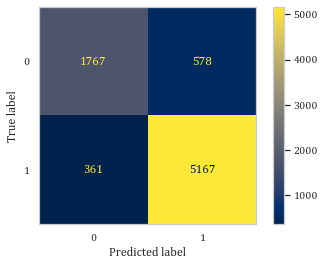

In [134]:
# print results for SVC model and plot confusion matrix, ROC curve

plot_matrix_rocauc_metrics(fallguys_svc_model, 'Support Vector Classifier', X_fallguys_train, X_fallguys_test, y_fallguys_train, y_fallguys_test)

### LSTM

In [ ]:
X_fallguys_lstm = lstm_tokenizer(X_fallguys, 200, 20000)

In [ ]:
y_fallguys_lstm = pd.get_dummies(y_fallguys).values[:, 1]

In [ ]:
# create training and testing sets for lstm

X_fallguys_train_lstm, y_fallguys_train_lstm, X_fallguys_test_lstm, y_fallguys_test_lstm = lstm_train_test_split(X_fallguys_lstm, 
                                                                                                                 y_fallguys_lstm, 
                                                                                                                 y_fallguys, 
                                                                                                                 0.25)

In [ ]:
# create lstm model

fallguys_lstm_model = create_lstm_model(X_fallguys_lstm, 20000, 200)

In [ ]:
fallguys_class_weights = generate_class_weights(y_fallguys)

In [ ]:
fallguys_history, fallguys_loss, fallguys_acc = lstm_model_fit_evaluate(fallguys_lstm_model,
                                                                        X_fallguys_train_lstm, 
                                                                        y_fallguys_train_lstm, 
                                                                        X_fallguys_test_lstm, 
                                                                        y_fallguys_test_lstm,
                                                                        class_weights = fallguys_class_weights,
                                                                        epochs=5,
                                                                        batch_size=50)

In [ ]:
lstm_metrics_plot(fallguys_lstm_model, fallguys_history, X_fallguys_test_lstm, y_fallguys_test_lstm)

In [ ]:
# create final lstm model

fallguys_lstm_model_final = create_lstm_model(X_fallguys_lstm, 20000, 200)

In [ ]:
fallguys_history, fallguys_loss, fallguys_acc = lstm_model_fit_evaluate(fallguys_lstm_model_final,
                                                                        X_fallguys_train_lstm, 
                                                                        y_fallguys_train_lstm, 
                                                                        X_fallguys_test_lstm, 
                                                                        y_fallguys_test_lstm,
                                                                        class_weights = fallguys_class_weights,
                                                                        epochs=2,
                                                                        batch_size=50)

In [ ]:
lstm_metrics_plot(fallguys_lstm_model_final, fallguys_history, X_fallguys_test_lstm, y_fallguys_test_lstm)

**Training Epochs**

![Results for Fall Guys - LSTM](./results/lstm_fallguys_epochs.png)

**Final ROC-AUC and Accuracy Scores**

![Results for Fall Guys - LSTM](./results/lstm_fallguys.png)

# Model Evaluation

The table below shows the overall results of the modelling using the various algorithms.

## Overall Results

![Results for ML-based Sentiment Analysis](./results/ml_sentiment_analysis.png)

SVC obtained the best accuracy amongst all the different classifiers. LSTM surprisingly did not perform as well as expected - possibly more care needs to be taken in preprocessing the data to remove more of the extraneous noise, increasing our sample size, or to experiment further with the tweaking of different parameters for the LSTM layers. It is also possible that a lot of the reviews were too short, and there was insufficient information for the network to make use of its retention of long-term dependencies.

---

Our aim is not just *predicting* the overall sentiments of the reviews, but more importantly, to *infer* which are the terms that allow us to discern whether the review is considered a positive/negative one. 

As such, we will focus our attention on the more easily interpretable models. We can see similar trends in all of the 3 games:

- **PUBG**: Logistic Regression outperformed the other 2 models, achieving a test ROC-AUC score of **0.9267**.
    - Support Vector Classifier performed best in terms of test accuracy
    - Naive Bayes Classifier also performed admirably as it is well suited to text-classification
    
    
- **Cyberpunk**: Logistic Regression outperformed the other 2 models, achieving a test ROC-AUC score of **0.9578**.
    - Support Vector Classifier performed best in terms of test accuracy
    - Naive Bayes Classifier also performed admirably as it is well suited to text-classification
    

- **Fall Guys**: Logistic Regression outperformed the other 2 models, achieving a test ROC-AUC score of **0.9364**.
    - Support Vector Classifier performed best in terms of test accuracy
    - Naive Bayes Classifier also performed admirably as it is well suited to text-classification
     
     
\**SVC's ROC-AUC score was not calculated as it is technically non-probabilistic; a hyperplane is used to separate the data points into the different classes.*

The **Logistic Regression** models all had high ROC-AUC scores of > 0.90 and performed admirably well in separating the negative class and positive class distributions, and was hence also able to predict negative and positive game reviews with a high degree of accuracy. All the accuracy scores are well above the baseline scores.

## Interpretation of Top Features

**PUBG**

- Positively correlated features
    - best
    - great
    - good
    - fun
    - love
    - amaze
    - awesome
    - friend
    - good game
    - addict
    - overall
    - complain
    
Positive reviews include the mention of 'friend' and 'addict' as some of the top terms - highlighting that it is an extremely enjoyable multiplayer game to play together with friends. Notably, we see the term 'overall' - indicating that many players also described their frustrations and gripes with the game, but still felt that on the whole it was a game worth recommending.

> Overall it is an enjoyable game. It fell off hard when fortnite and all of the other battle royales came around, but it still has the original sparkle that it once had. There are a lot of hardcore fans of this game that play religiously and they can be very frustrating to play against, however, the combat is fun and engaging. 7/10.
        
> It's generally a great game, has consistent updates and a pretty good season pass. It's fun to play with friends for the most part and has nice visual graphics if your PC can handle it. The only real complaint is the amount of cheaters and the lack of support by the developers to avoid them from popping up. Please come up with a better anti-cheat system and ban cheater steam accounts, not just their profiles.
        
- Negatively correlated features
    - money
    - bad
    - not
    - cheater
    - not worth
    - garbage
    - hacker
    - unplayable
    - waste
    - shit
    - trash
    - no
    - terrible
    - crash
    - refund

Unhappy players were highly vocal with their disgruntlement, highlighting their frustration with hackers and cheaters ruining the game experience, as well as gameplay issues that rendered the game unplayable or to crash. Several players complained that they were no longer able to obtain Steam refunds (this is only possible if you have not yet clocked 2 hours or more of gameplay). 'Money', interestingly became the top negatively correlated feature, which is quite telling ('refund my money', 'waste of money', 'money grubbing' (referring to microtransactions)).

Notably, PUBG was one of the most popular games on Steam that received a highly mixed aggregate score (almost a 50/50 split).

> The cheating is getting considerably worse all the time. It seems like the devs ban a bunch of cheaters at the beginning of a season to keep players interested but that quickly dies down and the cheating becomes even more rampant. This game can be fun but the anti cheating measures are not reliable or stringent enough and it really ruins the experience. The game would be redeemed if as much effort was put into these issues as making money off cosmetic items. Perhaps the devs could focus on making profits by fixing the game instead of making money off their obsession with stupid skins.

> After a 2 year break from the game, with occasionally booting the game for a few matches with friends, the game doesn't start for me. It's official. The game is dead and broken. Tried 3 forums, with multiple threads on how to fix the launching problem but no fix. A refund would be appreciated but a person can dream right?
Thanks "Blueballs"...

**Cyberpunk**

- Positively correlated features
    - amaze
    - great
    - love
    - far
    - fun
    - good
    - awesome
    - minor
    - yes
    - 10 
    - fantastic
    - enjoy
    - bit
    - perfect
    - definitely
    
Cyberpunk 2077 had been hyped by its creators for almost a decade to be a free-flowing, revolutionary experience that would immerse players in a sci-fi universe. Some players praised the complexity of the gameplay and the overall atmosphere of the game, which led to an amazing experience that lived up to their expectations. Many still acknowledged that there were minor bugs and issues present, but these were not serious enough to mar the overall enjoyment of the game. There was a large outpouring of support for the game developers, who had toiled continuously to deliver the game by its release date.

> Very atmospheric, great game play, voice acting, graphics, story, environments, npcs, and very complex RPG systems. Crafting, hacking, upgrading...lots of things to do. Very high quality. 
>
> Some things I don't like are that there's only one female and one male voice to choose from. I wanted to be a dude but his accent was annoying me so I went with female and that's a bit more neutral. Would also like to be able to visit a barber shop and change my hair, as well as have an animation where I eat. But aside from that, amazing game. 
>
> Obviously there are some bugs but those will get resolved and I wouldn't judge a game by temporary stuff like that.
        
> Simply an amazing game. 
>
> Bugs are minor on pc in my experience and I bet CDPR will fix them as soon as posible. 
>
> We need the option to "walk" in the game (pc version) and it would be nice if the missions could be sortet in the journal menu, for example according to distance from players current position. 
>
> There are som options in the skill three that aren't that balanced like the posibility to make some weapons OP because of crit multiplier and such, but you don't have to choose them so really not a problem for balance. 
>
> The crafting skill that breaks down "junk" automaticly, unfortunatly also breaks down valuable "junk". I wish CDPR would make a "valuables" tab aswell as the junk tab - on for getting crafting materials and on for quickly selling valuable items.
>
> Again - I love this game!!!!
        
- Negatively correlated features
    - refund 
    - boring
    - ai
    - not worth
    - unplayable
    - mess
    - even
    - crash
    - state
    - terrible
    - can
    - not recommend
    - unfinished
    - bad
    - can recommend
    
Unfortunately, due to the multitude of game-breaking issues and bugs on the last-gen console versions of the game (PlayStation 4 and Xbox One), Cyberpunk also made history by being one of the few games to be pulled from the PlayStation store after release by Sony. There were several angry gamers who also demanded refunds (this is the top negatively correlated feature) due to the game being unplayable due to bugs. Even when playable, the large number of glitches (e.g. character models spasming, tanks falling from the sky, barely functional AI behaviour) also adversely impacted the gameplay experience and made it feel like a highly unpolished, unfinished game.

> Terrible game full of glitches, horrible AI, and bland boring side missions. The fact that they advertised this as an RPG is insane as its nothing more than a rebranding of GTA but with none of the polish. CDPR should be in trouble for false advertising as well as delivering a completely unplayable game to ps4/xbox one users. Don't waste your money on this piece of shit.

> Sadly just EXTREMELY unfinished and mostly unplayable in its current state. No fun in challenge due to high peak in difficulty when playing in Hard; alongside the constant interruption of Buggy gameplay, audio, graphical issue and just straight up DUMB AI continue to bring me out of the game and am unwilling to sit through constant Save-Loading. Purchase at your own risk, I would recommend waiting for MANY future updates.

> The amount of bugs in this game is ridiculous. Sure, visually it looks really good in general, but the amount of graphical glitches completely takes away from that. I should have been told that I was buying a beta version of the game for \$60 before I bought it. Now I can't get a refund from Steam and playing this game is just frustrating. 2 hours wasn't long enough for me to make the decision that this game doesn't earn my money, but 16 hours in and now I have to force myself to play it. And no, I'm not going to wait for the patches to come out since I spent money on the game today with the understanding that I was buying a finished and complete product. Don't buy this game. They haven't earned your money.

**Fall Guys**

- Positively correlated features
    - fun
    - great
    - good
    - best
    - love
    - friend
    - amaze
    - 10 10
    - bean
    - fun game
    - laugh
    - though
    - funny
    - addict
    - good game

Being a relatively casual multiplayer party game (with a battle royale twist to it), Fall Guys received a warm reception from players who were looking to destress with friends (particularly during this challenging COVID-19 period). The gameplay is simple and easy to pick up, as espoused by gamers who quickly became addicted to it. The bright, pastel backgrounds and player characters which come in the form of cutely shaped 'beans' further add to the game's appeal. It is noted that a lot of positive reviews come with caveats about some downsides of the game (e.g. frustrating team-based mechanics, repetitiveness).

> This game is so ridiculously fun. It's mechanics though can be a little frustrating, it's still got some really good music, and it's incredibly addictive. I'm hoping in Season 3 we get new end maps and I'm excited for the other things coming <3

> Fall Guys is a physics-based battle-royale where you and up to 59 other jellybeans with limbs compete in various mini-games of different genres for crowns. And it is amazing. There's something about the stupidly hilarious frustration of watching your character tumble, stumble, trip, grab and leap their way over to a goal that few other games do.
>
>Not to mention, the way cosmetics are handles in this game makes me swoon. Fall Guys has a season pass that has always been (and it seems like it will always be) free. And while the Kudos you earn by playing games can be bought via micro-transactions, it is not at all necessary. Just playing a lot of games gets you the same amount. But the best part about it, and what keeps this game surprisingly competitive, is that crowns can be used to purchase top-tier cosmetic items. There's no way to buy them with cash; you just need to be determined enough to grind out enough crowns if you've been eyeing that crossover outfit.
>
>Fall Guys isn't without its flaws, though. For one, mini-games that split your lobby into teams are annoying as a concept, and still annoying in practice. Often times you feel like you're being held back by your team rather than your ability as a player. Even though Fall Guys isn't exactly an e-Sport, it always sucks to lose when it doesn't feel like your fault. This could be easily fixed if they made a separate show for team-based games and kept the main show for mini-games that anyone who queues alone can complete. I could also even see them allowing players to invite more than 3 people to queue for team-based mini-games; having a lobby of up to 16 players or something would be amazing for games like those. I suppose there is an issue once you have to split that team up via process of elimination, but I'm sure the developers can figure that out. I just would like to play a game on my own without having to deal with the team-based mini-games.
>
>Also, I won't sugarcoat it: The mini-games can get quite repetitive after long play sessions, or just over time. The developer team behind Fall Guys tried to solve this by adding random elements to the games, and while the effort is appreciated, it doesn't feel like enough at times. There either needs to be more randomness to courses, or just more courses in general to go through. However, I feel like as seasons come and go, courses will come in droves to keep us entertained.
>
>TL;DR: Fall Guys is one of the silliest, if not THE silliest, battle royale games out there. It's well worth your money.



- Negatively correlated features
    - not
    - refund
    - not worth
    - cheater
    - no 
    - hacker
    - boring
    - ruin
    - unplayable
    - shit
    - can
    - bad
    - repetitive
    - waste
    - trash
    
Upon release, Fall Guys was also the target of several hackers. They employed cheats allowing them to fly around the map and perform gravity-defying stunts, entirely bypassing obstacles in the map. It was hence easy for them to 'grief' other players and ruin their experience in this way, as there could only be one eventual winner for each game. 

Another common complain was that there was a fixed pool of minigames that was selected from for each round. After playing about 10 games or so, one would start seeing the same minigame over and over again, leading to several complaints of it being 'repetitive' and 'boring'.

> awful game, lost its traction and fun as they forgot real people exist and decided to leave hackers in for an entire 2 months.

> It is so repetitive it had so much hype then it came out and it sucked. I can't believe i spent $20 on this. it will bug out sometimes and is over run with hackers. no daily updates or mode changes.

> Enjoyed it at first.
Lost twice on Fall Mountain because either the grab doesnt work or your Fall Guy will climb on top, Lost Hex-a-Gon multiple times to hackers flying.
>
>It's fun for as long as the gimmick lasts. Once you've seen it all you've seen it all, and all that has changed since the last season is cosmetics, so it seems like it will remain the same game forever.

## Misclassification Analysis

In [120]:
# define function to generate dataframe with misclassified reviews

def misclass_predict(model, X_test, y_test, original_df):
    
    # obtain predictions from our LogisticRegression model
    model_pred = model.predict(X_test)
    
    # create dataframe with actual labels and predicted labels
    model_misclass_df = pd.DataFrame(data={'Actual': y_test, 'Predicted': model_pred})
    
    # filter the misclassified observations
    model_misclass_df = model_misclass_df[model_misclass_df['Actual'] != model_misclass_df['Predicted']]
    
    # combine the review with the actual label and predicted label, and display the first 5 rows
    model_misclass_df = pd.concat([pd.DataFrame(original_df[['review', 'lemmed_text']].loc[model_misclass_df.index]),
                                  model_misclass_df],
                                  axis=1)
    
    return model_misclass_df

In [121]:
# set maximum rows and colwidth to be displayed in dataframes

pd.options.display.max_rows = 150
pd.set_option('max_colwidth', 500)

### PUBG

In [122]:
pubg_misclass_df = misclass_predict(pubg_lr_model, X_pubg_test, y_pubg_test, pubg_df_ml)
pubg_misclass_df.head(10)

,review,lemmed_text,Actual,Predicted
42227,"It is a great game, the best BR game in my opinion, but it is far from perfect. Sadly the main priority of the game is to milk the current player base as much as possible for as long as they can. I don't really see this game developing or the player base growing from this point onward. \n\nAll they do now is to add new cosmetic crap. Even if you care about this stuff, all these items are paid and you have absolutely 0 access to them unless you pay. Even if you bought the last ""DLC"" which doe...",great game best br game opinion far perfect sadly main priority game milk current player base much possible long don't really see game develop player base grow point onward add new cosmetic crap even care stuff item paid absolutely 0 access unless pay even bought last dlc not deserve call dlc stupid repetitive boring mission still couldn't get cool stuff unless pay even more money,1,0
86950,"Main menu stops loading after about 10 hours of play. nothing really to work towards in terms of goals. Alot of ingame bugs that breaks the game. (Getting shot through walls, blowing up in your vehicle when driving on a flat road.)",main menu stop load 10 hour play nothing really work towards term goal alot ingame bug break game get shot wall blowing vehicle drive flat road,0,1
27653,"I played this game since closed beta. i loved it. i, and many others had high hopes for it to become the best battle royale experience ever. it had the potential. BUT that is not the case. It went downhill pretty fast and the devs are just like many others: Not listenting to the community and just cash grabbing.\nIt WAS a phenomenal experience!\nRest in Pepperonis my dear loved friend.",played game since close beta love many others high hope become best battle royale experience ever potential not case go downhill pretty fast devs like many others not listenting community cash grab phenomenal experience rest pepperoni dear love friend,0,1
93594,TBH I wanted to play this game. But it kept crashing when i loaded ingame for a couple minutes and IDK whats the deal or whats causing it. I heard the game is good and fun. But Im just too pissed off to tell if its the developments fault or its somehow me. Rip.,tbh want play game kept crash load ingame couple minute idk whats deal whats cause heard game good fun im piss tell development fault somehow rip,0,1
34822,"Game is fun to play but, still nothing like a special thing to support with all these bugs in the game. \nStill I will start with Pros.\nPros:\n- Overall Battle Royale is fun and concept is good.\n- Weapons are good to use\n- Fun to play with friends\n\nCons:\n-Still poorly optimzed. Even with high fps the game stutters a lot.\n- Server lags and people in specific regions has advantages.\n- The game physics sucks. Vehicles just bounces off randomly. Sometimes get killed because of this too.\...",game fun play still nothing like special thing support bug game still start pro pro overall battle royale fun concept good weapon good use fun play friend con still poorly optimzed even high fps game stutter lot server lag people specific region advantage game physic suck vehicle bounce randomly sometimes get kill lot hacker game randomly approach shoot even aim find deathcams yeah play much hour find game total waste don't recommend,0,1
52460,"It's not perfect, but it's solid. \n\nThe gunplay is some of the best. \n\nLoot distribution needs a bit of work on all maps.\n\nAll regions need a hard ping lock of 100 in my opinion... with maybe a random region with unlocked ping for the shitty internet of the world and people living in BFE.\n\nIf you haven't played and decide to buy, don't waste your money on crates and give yourself plenty of time to get used to the game's movement mechanics as it's meant to be REALLY clunky to keep fro...",not perfect solid gunplay best loot distribution need bit work map region need hard ping lock 100 opinion maybe random region unlocked ping shitty i

Many of the reviews above would be somewhat difficult for a machine to predict, as a number contain mixed sentiments at various points in time e.g. used to like the game due to gameplay, but subsequently got frustrated by lag/hackers (**27653**). It is likely that there were roughly an equal distribution of positive and negative sentiment words. 

Some bugs which are relatively descriptive in nature ('getting shot through walls', 'blowing up in your vehicle when driving along a flat road') may be misconstrued to be gameplay elements which are typical of positive reviews as well. (**86950**)

Texts that are rife with slang (**67131**) are not easily understood by the model.

While negative words are somewhat accounted for using n-grams in our models (bigrams - 'not good', 'don't buy'), the model may still have difficulty predicting the correct sentiment if they do not appear often enough. (**94112**)

Similarly, in the last review (**79621**), we also see that the model is unable to deal with comments that do not quite make logical sense (looking at the review, there is no clear sentiment at all).

### Cyberpunk

In [123]:
cyberpunk_misclass_df = misclass_predict(cyberpunk_lr_model, X_cyberpunk_test, y_cyberpunk_test, cyberpunk_df_ml)
cyberpunk_misclass_df.head(10)

,review,lemmed_text,Actual,Predicted
383,"While the open world has potential after some changes are made, and the combat and music were enjoyable, this game really didn't seem to say anything. I'm not sure what the themes were past a very surface-level anti-corporate commentary. A lot of content seems to have been cut, leading to an experience of tonal dissonance.",open world potential change make combat music enjoyable game really didn't seem say anything i'm not sure theme past surface level anti corporate commentary lot content seem cut lead experience tonal dissonance,0,1
44225,"There is just a certain flatness to the game with no RTX. Characters dont cast shadows etc. Hellblade looks and runs wayy better, I'm torn.",certain flatness game no rtx character dont cast shadow etc hellblade look run wayy well i'm torn,0,1
39710,Far cry 3 had better stealth and gunplay than this.\nFallout 4 had more engaging dialogues and character customization than this.\nGTA San Andres had better vehicle control and AI than this.\nDeath Stranding had better facial performance and story than this.\n\nBut...\n\nThis game has the best level design \nThis game has the most sexual settings\nThis game 'had' a lot of hype...,far cry 3 well stealth gunplay fallout 4 more engage dialogue character customization gta san andres well vehicle control ai death strand well facial performance story game best level design game most sexual setting game 'had' lot hype,0,1
19879,"A great adventure game and a horrible open world rpg. Doing side missions and the main quest line has been fun, but the game falls apart in every open world aspect and fails to be immersive outside the missions. Doing anything in the open world just kills the fun for me, stuff like getting a car is just a text message and walking up to a random car, going to a bar in game looks cool but you cant even sit and order a drink. There was a lot of cut content in this game that really could have ma...",great adventure game horrible open world rpg side mission main quest line fun game fall apart every open world aspect fails immersive outside mission anything open world kill fun stuff like get car text message walk random car go bar game look cool cant even sit order drink lot cut content game really could make masterpiece like subway go fast travel game get cut instead get random fast travel box brain dance also cut content even buy brain dance store place misc tab inventory serve no funct...,0,1
21439,"Really cool, but also really a lot of bugs for a ""AAA"". I guess they wanted to pump out as much as possible. Some parts get really broken where you just have to close the game and reaload the last checkpoint - like for example if you fast TAB, the inspection will lock without any other way of unlocking it other than reloading a save. \nOr if you're really unlucky it will crahs by iteself randomly. \n\nBut story's really cool and the soundtrack also. \nQA not up to paar for a tripple A. \nMix...",really cool also really lot bug aaa guess want pump much possible part get really broken close game reaload last checkpoint like example fast tab inspection lock without way unlock reload save really unlucky crahs iteself randomly story's really cool soundtrack also qa not paar tripple mixed feeling,0,1
43487,"8 years in development!! come on! W3 is far superior. Also this should be smooth as hell!!\n\n6/10 at best, first impressions aint good.\n\nThrust into the game with so much coming my way and little info. i still have no idea whats going on. \n\nRelease date should of been 10 Dec 2021\n\nif things change during game time I'll update this if possible.",8 year development come w3 far superior also should smooth hell 6 10 best first impression aint good thrust game much come way little info still no idea whats go release date should 10 dec 2021 thing change game time i'll update possible,0,1
23928,"GTA 5 AND FALLOUT 4 HAD A BABY??????? LOOT, SHOOT, FOLLOW MINI-MAP, AND SELECT YELLOW DIALOGUE OPTION

Some of the misclassification also stems from how Logistic Regression is unable to predict more advanced phrases such as 'kill the fun' (**19879**). Otherwise, several of the misclassified reviews also contain mixed sentiments that toe the line between a overall positive and negative score. 

### Fall Guys

In [124]:
fallguys_misclass_df = misclass_predict(fallguys_lr_model, X_fallguys_test, y_fallguys_test, fallguys_df_ml)
fallguys_misclass_df.head(10)

,review,lemmed_text,Actual,Predicted
8139,game is rigged\nyellow team always loses\ni never win because other people are bad at seesaw\n\n\n\n...\n\n\n\n\n\nnah this games tight,game rig yellow team always loses never win people bad seesaw nah game tight,0,1
9760,"Fall Guys is a really exciting game that will keep you at the top of your toes. All the events are extremely funny and the visuals are adorble. The characters, the stages, the bounce effect, sounds, its a cuteness overload, and I do really recomend you to buy it. But this review has a really big stain atm, which is the hackers. Not only there's hundreds of them, but you can't report them.",fall guy really excite game keep top toe event extremely funny visuals adorble character stage bounce effect sound cuteness overload really recomend buy review really big stain atm hacker not only there's hundred can't report,0,1
25769,Enjoyable but I wouldn't recommend until they make a team mini game only/ffa only mode. Most of the team mini games either have very one sided metas or your own teammates play against you.\n\nFun as hell with friends but infuriating when on the Roller game everyone just picks a left or right track to hold the ball.\n,enjoyable wouldn't recommend make team mini game only ffa only mode most team mini game either one side metas teammate play fun hell friend infuriate roller game everyone pick left right track hold ball,0,1
11163,whenever i load into a match it just disconnects me from the server. if anyone knows how to fix this issue pls help,whenever load match disconnect server anyone know fix issue pls help,1,0
3542,"Fall Guys has no business being this incomplete at $25 in 2020, but it's still a lot of fun. I've yet to get tired of stumbling past three rounds of noobs to jockey against the upper crust of that show's players on (almost exclusively) Fall Mountain after 30+ hours, so I've gotten at least an hour of fun (often shared with friends in couch hot seat play) per dollar and can't really complain, but seriously:\n\nWhy are there so few cosmetic options immediately available to the new player, as t...",fall guy no business incomplete 25 2020 still lot fun i've yet get tire stumble past three round noobs jockey upper crust show's player almost exclusively fall mountain 30 hour i've gotten least hour fun often share friend couch hot seat play per dollar can't really complain seriously cosmetic option immediately available new player allow stand crowd player still not customize name nothing load screen rocket league let practice free play queue player not least rotate camera around fall guy w...,1,0
28730,"Nice, new season caters to casuals and gives away crowns. New modes suck ass. First season was great, I had almost 30 wins which isn't a lot but now it doesn't feel earned with how casual this shit is now.",nice new season caters casuals give away crown new mode suck as first season great almost 30 win isn't lot feel earn casual shit,0,1
13141,The game is quite fun but:\n\nThere are a lot of disconnects and matchmaking problems. \nThese issues make it hard to play and enjoy the game.\nIt's even more infuriating if you play with friends.\n\nFix the servers.,game quite fun lot disconnect matchmaking problem issue make hard play enjoy game even more infuriate play friend fix server,0,1
1198,"This game taught me how many stupid people there still are in the world...\n\nLet's get real here after you play it a while with your friends there is just nothing new. You play the crap out of the maps, win a few times.... it gets old. Then you either wait for an update or uninstall. I can't imagine it takes them months to make new maps. They need to re-prioritize or something if they want longevity in this game.",game taught many stupid people still world let's get real play friend nothing new play crap map win time get old either wait update uninstall can't imagine take month make new map need prioritize something want longevity game,1,0
1992,Perhaps the onl

Some of the reviews seem to contradict their content (**11163**, **1198**). The model is also not adept at detecting witty/snarky comments (**1992**) - indeed, sarcasm detection using machine learning is one of the most difficult aspects of NLP, that is still being studied today.

## Model Limitations

Our models contain a fair number of limitations despite their high accuracy:

- As seen in the earlier section, many of the posts may contain **multiple sentiments** - it is not a clear negative or positive review. This may lead to the classifier predicting incorrectly that it is of the opposite sentiment.

- Model **cannot generalize too well between different games** - the code below shows the output of using the model trained on Cyberpunk's corpus on PUBG and Fall Guys. The poorer accuracy is somewhat to be expected as the three games are of very different genres. The gameplay aspects in each game hence vary greatly from each other - for instance, there is no shooting of any kind in Fall Guys, while PUBG contains rifles, shotguns, grenades and a myriad of others. Hence, while certain adjectives (fun, amazing) can be generically applied to all games, many of the game-specific terms would not be directly translatable between games.
    - Future models for games of other genres can be developed by simply applying the same pre-processing steps, to be trained on the new corpus
    
```
cyberpunk_lr_model.score(X_pubg_test, y_pubg_test)
> 0.6740451812124167

cyberpunk_lr_model.score(X_fallguys_test, y_fallguys_test)
> 0.7859773910834498
```

- Our models are unable to deal with more advanced NLP problems (e.g. recognition of sarcasm)
- Several less obstrusive, spam comments (e.g. 'copypasta' - blocks of text that resembles actual speech that are repeatedly copied and pasted by commenters) were not able to be detected and filtered during the pre-processing stage, resulting in noise during the modelling)
- Model accuracy is highly dependent on the cleanliness/structure of the data - unlike social media forums like reddit where there tends to be better formatting of comments and moderation in place (to remove senseless spam comments), Steam reviews are haphazard and somewhat more difficult to extract insight from


We next move on to perform topic modelling and attempt classification of our reviews to determine their dominant topics.